# Airbnb Listing Price Part Two: predict the price using Tree & NN
January,2024</br>
Feburary,2024(latest edition)</br>
In this part I've done some advanced feature engineering based on https://www.kaggle.com/datasets/zhudig123/airbnb-dataset-from-group-7, then I used Xgboost, Adaboost, RF and ANN separately to predict the price in the dataset and use RMSE as the metric to evalute the performance of each models. Finally I tried to use Stacking to combine some models. The project found that Xgboost has the best performance.

<h1>Outline<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Part-One:-Feature-Engineering" data-toc-modified-id="Part-One:-Feature-Engineering-1">Part One: Feature Engineering</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#One.Overview-of-the-dataset" data-toc-modified-id="One.Overview-of-the-dataset-1.0.1">One.Overview of the dataset</a></span></li><li><span><a href="#Two.Review:-'distance'" data-toc-modified-id="Two.Review:-'distance'-1.0.2">Two.Review: 'distance'</a></span></li><li><span><a href="#Three.Flatten-the-'amenities'-feature." data-toc-modified-id="Three.Flatten-the-'amenities'-feature.-1.0.3">Three.Flatten the 'amenities' feature.</a></span></li><li><span><a href="#Four.Gaussian-Mixture" data-toc-modified-id="Four.Gaussian-Mixture-1.0.4">Four.Gaussian Mixture</a></span><ul class="toc-item"><li><span><a href="#(1)&quot;host&quot;-class-features" data-toc-modified-id="(1)&quot;host&quot;-class-features-1.0.4.1">(1)"host" class features</a></span></li><li><span><a href="#(2)&quot;Apartment&quot;-class-features" data-toc-modified-id="(2)&quot;Apartment&quot;-class-features-1.0.4.2">(2)"Apartment" class features</a></span></li><li><span><a href="#(3)&quot;Review&quot;-class-features" data-toc-modified-id="(3)&quot;Review&quot;-class-features-1.0.4.3">(3)"Review" class features</a></span></li></ul></li><li><span><a href="#Five.Feature-selection" data-toc-modified-id="Five.Feature-selection-1.0.5">Five.Feature selection</a></span></li></ul></li></ul></li><li><span><a href="#Part-Two:-Model-Training" data-toc-modified-id="Part-Two:-Model-Training-2">Part Two: Model Training</a></span><ul class="toc-item"><li><span><a href="#Model-1：Xgboost" data-toc-modified-id="Model-1：Xgboost-2.1">Model 1：Xgboost</a></span><ul class="toc-item"><li><span><a href="#Version-1.0：train-it-directly" data-toc-modified-id="Version-1.0：train-it-directly-2.1.1">Version 1.0：train it directly</a></span></li><li><span><a href="#Version-2.0：log-the-target-variable" data-toc-modified-id="Version-2.0：log-the-target-variable-2.1.2">Version 2.0：log the target variable</a></span></li><li><span><a href="#Version-3.0:Use-Optuna-for-hyperparameter-tuning." data-toc-modified-id="Version-3.0:Use-Optuna-for-hyperparameter-tuning.-2.1.3">Version 3.0:Use Optuna for hyperparameter tuning.</a></span></li></ul></li><li><span><a href="#Model-2：Adaboost" data-toc-modified-id="Model-2：Adaboost-2.2">Model 2：Adaboost</a></span></li><li><span><a href="#Model-3：Random-Forest" data-toc-modified-id="Model-3：Random-Forest-2.3">Model 3：Random Forest</a></span></li><li><span><a href="#Model-4：Stacking" data-toc-modified-id="Model-4：Stacking-2.4">Model 4：Stacking</a></span></li></ul></li><li><span><a href="#Part-Three:-Results" data-toc-modified-id="Part-Three:-Results-3">Part Three: Results</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#One.RMSE" data-toc-modified-id="One.RMSE-3.0.1">One.RMSE</a></span></li><li><span><a href="#Two.Feature-Importance" data-toc-modified-id="Two.Feature-Importance-3.0.2">Two.Feature Importance</a></span></li></ul></li><li><span><a href="#（Updated）Model-5：ANN" data-toc-modified-id="（Updated）Model-5：ANN-3.1">（Updated）Model 5：ANN</a></span></li></ul></li></ul></div>

In [126]:
#import the required database.
from kaggle.api.kaggle_api_extended import KaggleApi
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import cross_val_score

import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.callbacks import LearningRateScheduler

import optuna

import joblib

#In this project, the random seed for all random processes is set to 111.
seed = 111

In [5]:
 #use Kaggle's API to download data
!kaggle datasets download -d zhudig123/airbnb-dataset-from-group-7 --unzip -w --force -q

## Part One: Feature Engineering
This part builds upon Project One and conducts further exploration of the dataset. New features are constructed, and the experiences from the midterm are summarized. Additionally, there is a change in the method used to reduce the dimensionality of the dataset.
#### One.Overview of the dataset

In [3]:
#import and view the data
data = pd.read_csv('final_exam_data.csv')
data.head()

listing_id  price(dollar)  \
0      281420        62.4923   
1     3705183       141.4920   
2     4082273       104.9399   
3     4797344        68.3878   
4     4823489        70.7460   

                                               name   host_id  host_since  \
0    Beautiful Flat in le Village Montmartre, Paris   1466919  2011-12-03   
1                   39 mÃÂ² Paris (Sacre CÃ
âur)  10328771  2013-11-29   
2               Lovely apartment with Terrace, 60m2  19252768  2014-07-31   
3               Cosy studio (close to Eiffel tower)  10668311  2013-12-17   
4  Close to Eiffel Tower - Beautiful flat : 2 rooms  24837558  2014-12-14   

   host_duration                 host_location host_response_time  \
0           3543  Paris, Ile-de-France, France     within an hour   
1           2816  Paris, Ile-de-France, France     within an hour   
2           2572  Paris, Ile-de-France, France     within an hour   
3           2798  Paris, Ile-de-France, France     within an hour   
4           2436  Paris, Ile-de-France, France     within an hour   

   host_response_rate  host_acceptance_rate  ...  Rio de Janeiro   Rome  \
0                 1.0                   1.0  ...           False  False   
1                 1.0                   1.0  ...           False  False   
2                 1.0                   1.0  ...           False  False   
3                 1.0                   1.0  ...           False  False   
4                 1.0                   1.0  ...           False  False   

   Sydney  Hotel room Private room Shared room  instant_bookable_t  \
0   False       False        False       False                True   
1   False       False        False       False                True   
2   False       False        False       False                True   
3   False       False        False       False                True   
4   False       False        False       False                True   

   instant_bookable_f  distance  \
0               False  0.827539   
1               False  0.801189   
2               False  0.810585   
3               False  0.528713   
4               False  0.676304   

                                           amenities  
0  ["Heating", "Kitchen", "Washer", "Wifi", "Long...  
1  ["Shampoo", "Heating", "Kitchen", "Essentials"...  
2  ["Heating", "TV", "Kitchen", "Washer", "Wifi",...  
3  ["Heating", "TV", "Kitchen", "Wifi", "Long ter...  
4  ["Heating", "TV", "Kitchen", "Essentials", "Ha...  

[5 rows x 51 columns]

In [4]:
#view feature names for constructing new features later
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274034 entries, 0 to 274033
Data columns (total 51 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   listing_id                   274034 non-null  int64  
 1   price(dollar)                274034 non-null  float64
 2   name                         274034 non-null  object 
 3   host_id                      274034 non-null  int64  
 4   host_since                   274034 non-null  object 
 5   host_duration                274034 non-null  int64  
 6   host_location                274034 non-null  object 
 7   host_response_time           274034 non-null  object 
 8   host_response_rate           274034 non-null  float64
 9   host_acceptance_rate         274034 non-null  float64
 10  host_is_superhost            274034 non-null  bool   
 11  host_total_listings_count    274034 non-null  float64
 12  host_has_profile_pic         274034 non-null  bool   
 13 

I'll process the features in 'object' type for further analysis.

In [5]:
#encode 'host_response_time' with ordinal encoding to preserve the meaningful order for feature reduction purposes
response_time = {'within an hour':1,
                 'within a few hours':2,
                 'within a day':3,
                 'a few days or more':4}
data['host_response_time'] = data['host_response_time'].map(response_time)

In [6]:
#for other categorical data with numerous categories, perform label encoding
#'host_location'
enc = preprocessing.LabelEncoder()
enc1 = enc.fit(data['host_location'])
data['host_location'] = enc1.transform(data['host_location'])

#'neighborhood'
enc2 = enc.fit(data['neighbourhood'])
data['neighbourhood'] = enc2.transform(data['neighbourhood'])

#'property_type'
enc3 = enc.fit(data['property_type'])
data['property_type'] = enc3.transform(data['property_type'])

#'room_type'
enc3 = enc.fit(data['room_type'])
data['room_type'] = enc3.transform(data['room_type'])

#### Two.Review: 'distance'
'Distance' is the most important feature I constructed in Part One. Here, I have replicated the approach for constructing this feature and improved its visualization.

In [7]:
#view geographic location data
location = data[['latitude','longitude','city','price(dollar)',
                 'Paris','New York','Bangkok','Rio de Janeiro','Sydney','Istanbul',
                 'Rome','Mexico City','Cape Town']]
city = location['city'].unique()
location

latitude  longitude       city  price(dollar)  Paris  New York  \
0       48.88668    2.33343      Paris      62.492300   True     False   
1       48.88617    2.34515      Paris     141.492000   True     False   
2       48.88112    2.31712      Paris     104.939900   True     False   
3       48.84571    2.30584      Paris      68.387800   True     False   
4       48.85500    2.26979      Paris      70.746000   True     False   
...          ...        ...        ...            ...    ...       ...   
274029 -33.93503   18.40655  Cape Town      59.780160  False     False   
274030 -34.13698   18.32700  Cape Town      50.473476  False     False   
274031 -34.10384   18.47468  Cape Town      36.887076  False     False   
274032 -34.11988   18.82970  Cape Town      27.172800  False     False   
274033 -33.79250   18.45890  Cape Town      67.932000  False     False   

        Bangkok  Rio de Janeiro  Sydney  Istanbul   Rome  Mexico City  \
0         False           False   False     False  False        False   
1         False           False   False     False  False        False   
2         False           False   False     False  False        False   
3         False           False   False     False  False        False   
4         False           False   False     False  False        False   
...         ...             ...     ...       ...    ...          ...   
274029    False           False   False     False  False        False   
274030    False           False   False     False  False        False   
274031    False           False   False     False  False        False   
274032    False           False   False     False  False        False   
274033    False           False   False     False  False        False   

        Cape Town  
0           False  
1           False  
2           False  
3           False  
4           False  
...           ...  
274029       True  
274030       True  
274031       True  
274032       True  
274033       True  

[274034 rows x 13 columns]

In [8]:
#dynamically create multiple DataFrames, each representing latitude and longitude data for different cities
for i in range(len(city)):
    exec("city{} = location[location['city']=='{}'][['latitude','longitude','price(dollar)']]".format(i,city[i]))

In [9]:
#Visualize with a 3D scatter plot, using 'latitude' and 'longitude' as the x and y axes respectively, and 'price(dollar)' as the z-axis.
citylist = [city0,city1,city2,city3,city4,
            city5,city6,city7,city8,city9]

fig = plt.figure(figsize=(50,20))
for i in range(2):
    for j in range(5):
        num = i*5+j
        city_draw = citylist[num]
        ax = fig.add_subplot(2,5,num+1,projection='3d')
        ax.scatter(city_draw['latitude'],city_draw['longitude'],city_draw['price(dollar)'],c=city_draw['price(dollar)'],cmap='coolwarm')
        ax.set_title(city[num])

plt.show()

From the visualization, it's evident that for some areas, there's a noticeable trend where house prices tend to be higher the closer they are to the city center. Additionally, the data points are not concentrated in a small area but rather spread across the entire city, suggesting that averaging their coordinates can roughly determine the city center's location.</br>
Based on this, I propose averaging all coordinates for each city to determine its city center. Then, calculate the distance from each sample point to its corresponding city center. Normalize these distances for each city to create the "distance".

#### Three.Flatten the 'amenities' feature.
I've done this section in Part one Actually, but I have use PCA for dimensionality reduction which actually waste a lot of information in these variables. Hence I constructed it again and would process it differently this time.

In [10]:
#convert the lists in the 'amenities' column from string format to Python lists
amenity = data['amenities']
amenity = amenity.apply(eval)

#Fflatten the nested lists and output the top 5 most frequent elements.
def flatten(series):
    return pd.Series([x for _list in series for x in _list])

amenity_count = flatten(amenity).value_counts()
print(amenity_count[:5])

Wifi                       254971
Essentials                 248786
Long term stays allowed    236262
Kitchen                    236241
TV                         209111
Name: count, dtype: int64


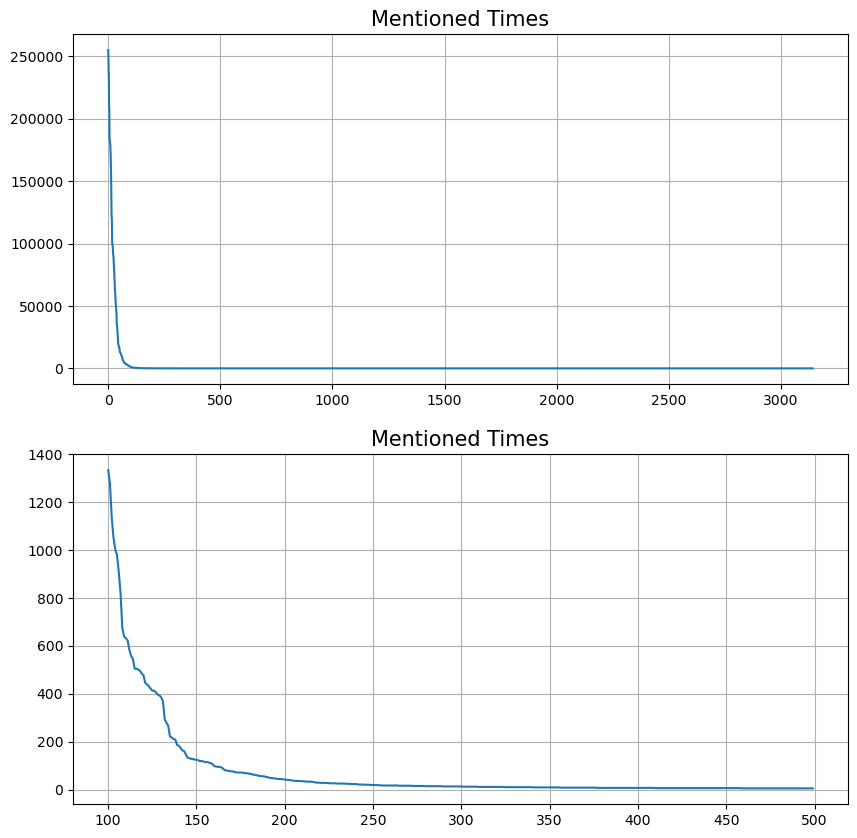

In [11]:
#visualize the frequency of each tag mentioned in the 'amenity' feature
fig,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(amenity_count.values)
ax[0].set_title('Mentioned Times',fontsize=15)
ax[0].grid()

x = [i for i in range(100,500)]
ax[1].plot(x,amenity_count.values[100:500])
ax[1].set_title('Mentioned Times',fontsize=15)
ax[1].grid()
plt.show()

When an "amenity" is mentioned very infrequently, its impact on improving the model's performance will be very limited. Therefore, I will remove options that appear too infrequently and convert the remaining ones into dummy variables.

In [12]:
%%time
def boolean(df, unique_items):
    bool_dict = {}

    #iterate over each label.
    for i, item in enumerate(unique_items):
        bool_dict[item] = df.apply(lambda x: item in x)

    return pd.DataFrame(bool_dict)

#convert items mentioned in the 'amenities' column more than 1% of the total samples into boolean values
amenity_top = amenity_count[amenity_count>=(0.01*len(data))]
amenity_bool = boolean(amenity,amenity_top.keys())
amenity_int = amenity_bool.astype(int)

print("The shape of matrix is:",amenity_int.shape)

The shape of matrix is: (274034, 87)
CPU times: total: 13.5 s
Wall time: 20.4 s


In [13]:
#add the expanded features back into the feature set
data = data.join(amenity_int)
data = data.drop(columns='amenities')

#### Four.Gaussian Mixture
My idea in this section is to let unsupervised algorithms autonomously discover the underlying commonalities among the data, thereby using these commonalities as new indicators.

In [14]:
#to avoid data leakage, split the dataset here before feature engineering
X = data.drop('price(dollar)',axis=1)
Y = data['price(dollar)']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=seed)

To facilitate the unsupervised algorithm's autonomous discovery of common features among samples, I will divide the features into three categories and perform unsupervised clustering on each category separately.

In [15]:
#based on the characteristics of the data, divide the data that needs to be clustered into three categories
host = ['host_duration','host_location','host_response_time','host_response_rate',
        'host_acceptance_rate','host_is_superhost','host_total_listings_count',
        'host_has_profile_pic','host_identity_verified']
host_train = X_train[host]
host_test = X_test[host]

apartment = ['property_type','room_type','accommodates','bedrooms',
           'minimum_nights','maximum_nights']
apartment_train = X_train[apartment]
apartment_test = X_test[apartment]

review = ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
          'review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']
review_train = X_train[review]
review_test = X_test[review]

##### (1)"host" class features
I use the Gaussian mixture algorithm for unsupervised clustering here. Compared to hard clustering algorithms like K-Means, soft clustering algorithms are more friendly to samples that lie between two clear categories. The same applies to the other two categories of features.

In [16]:
%%time
n_comp = np.arange(1,11)

#use Gaussian mixture model to cluster features
models1 = [GMM(n,covariance_type='full',random_state=seed).fit(host_train)
          for n in n_comp]

CPU times: total: 5min 55s
Wall time: 4min 5s


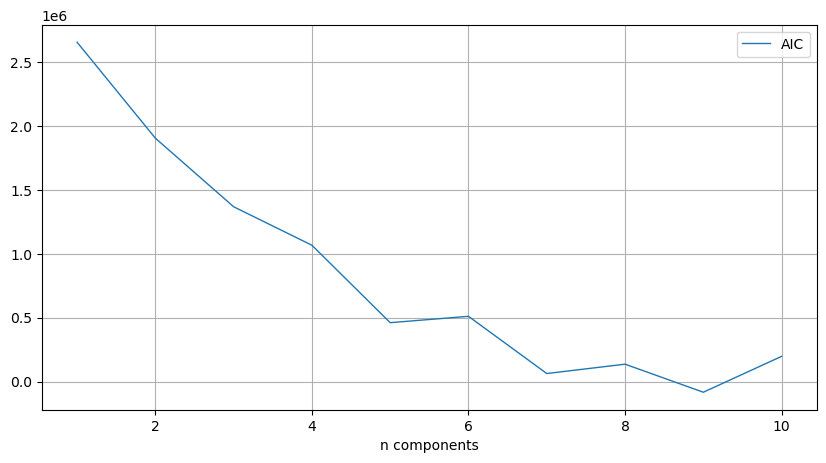

In [17]:
#visualize, a lower AIC indicates a better balance between simplicity and effectiveness for the corresponding number of clusters
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(n_comp, [m.aic(host_test) for m in models1],label='AIC',lw=1)
ax.legend(loc='best')
ax.grid()
ax.set_xlabel('n components')
plt.show()

In [49]:
#train the model using the n components corresponding to the minimum AIC
#only use samples from the training set to prevent data leakage.
%%time
gmm1 = GMM(n_components=9).fit(host_train)

CPU times: total: 27 s
Wall time: 31.9 s


In [70]:
#add the probabilities of each sample belonging to each cluster as new features to the dataset
host_feat_train = pd.DataFrame(gmm1.predict_proba(host_train),
                               index=X_train.index,
                               columns=['host' + str(i) for i in range(9)])
X_train = X_train.join(host_feat_train)

#use the trained model, trained on the training set, to predict results for the test set
host_feat_test = pd.DataFrame(gmm1.predict_proba(host_test),
                              index=X_test.index,
                              columns=['host' + str(i) for i in range(9)])
X_test = X_test.join(host_feat_test)

##### (2)"Apartment" class features

In [84]:
%%time
n_comp = np.arange(1,21)

#use the Gaussian mixture model to cluster features
models2 = [GMM(n,covariance_type='full',random_state=seed).fit(apartment_train)
          for n in n_comp]

CPU times: total: 3min 58s
Wall time: 8min 55s


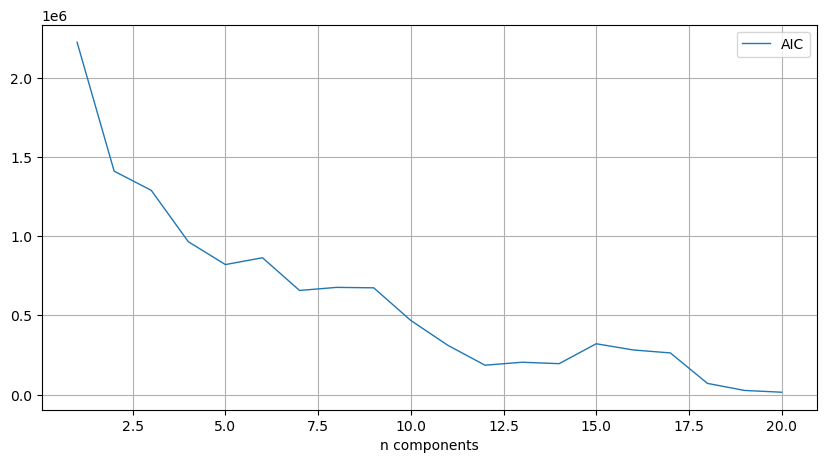

In [85]:
#visualize, a lower AIC indicates a better balance between simplicity and effectiveness for the corresponding number of clusters
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(n_comp, [m.aic(apartment_test) for m in models2],label='AIC',lw=1)
ax.legend(loc='best')
ax.grid()
ax.set_xlabel('n components')
plt.show()

In [86]:
#train the model using the n components corresponding to the minimum AIC
#only use samples from the training set to prevent data leakage.
%%time
gmm2 = GMM(n_components=18).fit(apartment_train)

CPU times: total: 33.5 s
Wall time: 1min 12s


In [91]:
#add the probabilities of each sample belonging to each cluster as new features to the dataset
apartment_feat_train = pd.DataFrame(gmm2.predict_proba(apartment_train),
                                    index=X_train.index,
                                    columns=['apartment' + str(i) for i in range(18)])
X_train = X_train.join(apartment_feat_train)

#use the trained model, trained on the training set, to predict results for the test set
apartment_feat_test = pd.DataFrame(gmm2.predict_proba(apartment_test),
                                   index=X_test.index,
                                   columns=['apartment' + str(i) for i in range(18)])
X_test = X_test.join(apartment_feat_test)

##### (3)"Review" class features

In [92]:
%%time
n_comp = np.arange(1,11)

#use Gaussian mixture model to cluster features
models3 = [GMM(n,covariance_type='full',random_state=seed).fit(review_train)
          for n in n_comp]

CPU times: total: 1min 21s
Wall time: 2min 7s


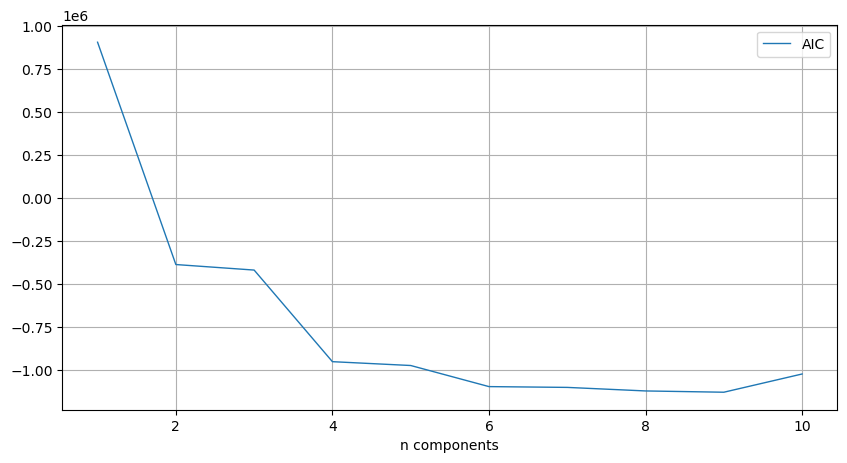

In [93]:
#visualize, a lower AIC indicates a better balance between simplicity and effectiveness for the corresponding number of clusters
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(n_comp, [m.aic(review_test) for m in models3],label='AIC',lw=1)
ax.legend(loc='best')
ax.grid()
ax.set_xlabel('n components')
plt.show()

In [94]:
#train the model using the n components corresponding to the minimum AIC
#only use samples from the training set to prevent data leakage.
%%time
gmm3 = GMM(n_components=6).fit(review_train)

CPU times: total: 4.33 s
Wall time: 9.53 s


In [101]:
#add the probabilities of each sample belonging to each cluster as new features to the dataset
review_feat_train = pd.DataFrame(gmm3.predict_proba(review_train),
                                 index=X_train.index,
                                 columns=['review' + str(i) for i in range(6)])
X_train = X_train.join(review_feat_train)

#use the trained model, trained on the training set, to predict results for the test set
review_feat_test = pd.DataFrame(gmm3.predict_proba(review_test),
                                index=X_test.index,
                                columns=['review' + str(i) for i in range(6)])
X_test = X_test.join(review_feat_test)

#### Five.Feature selection
Although some models like tree-based models have no strict requirements on data dimensionality, reducing the dimensionality of features can effectively improve the speed of model training.</br>
In part one, I attempted to use PCA to reduce the dimensionality of features, but the results showed that this approach was not effective. I believe the main reason lies in the presence of a large number of frequently occurring but ineffective features in the model. PCA mixes truly effective features with these features, leading to the extraction of low-dimensional orthogonal features that may undermine the truly effective features.</br>
Therefore, here I will use feature selection to achieve dimensionality reduction of the dataset. The main idea is to first train a random forest model and then perform feature selection based on the permutation performance of each feature during training.

In [2]:
X_train = pd.read_csv('.\\tmp\\X_train_gauss.csv',index_col=0)
X_test = pd.read_csv('.\\tmp\\X_test_gauss.csv',index_col=0)
Y_train = pd.read_csv('.\\tmp\\Y_train_gauss.csv',index_col=0)
Y_test = pd.read_csv('.\\tmp\\Y_test_gauss.csv',index_col=0)

In [3]:
#remove some variables that couldn't be transformed into numerical type
drop_col = ['listing_id','name','host_id','host_since',
            'within a day','within a few hours','within an hour','city',
            'instant_bookable','instant_bookable_f','room_type']

X_train.drop(drop_col,axis=1,inplace=True)
X_test.drop(drop_col,axis=1,inplace=True)

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219227 entries, 94930 to 129900
Columns: 158 entries, host_duration to review5
dtypes: bool(16), float64(47), int64(95)
memory usage: 242.5 MB


Currently, there are a total of 158 numerical features in the dataset. To reduce the time complexity and enhance the model's generalization ability, I will first use random forest, which can handle high-dimensional data, to perform feature selection.

In [8]:
%%time
#train the model and do feature selection
forest = RandomForestRegressor(n_estimators=500, max_leaf_nodes=64,n_jobs=-1,random_state=seed)
forest.fit(X_train,np.array(Y_train).reshape(-1))

CPU times: total: 1h 13min 9s
Wall time: 9min 45s


RandomForestRegressor(max_leaf_nodes=64, n_estimators=500, n_jobs=-1,
                      random_state=111)

In [9]:
#calculate feature importance and visualize
feat_import_value = forest.feature_importances_
feat_name = X_train.columns

#select the feature that has a higher weight
thresh = 0.0001
feat_name_chose = feat_name[feat_import_value >= thresh]
feat_value_chose = feat_import_value[feat_import_value >= thresh]

#visualize
fig,ax = plt.subplots(figsize=(15,7))
ax.barh(feat_name_chose,feat_value_chose)
ax.set_xlabel('feature importance')
ax.set_ylabel('feature')
ax.grid()
plt.show()

The importance of features in the training set can serve as the basis for selection, but to ensure better generalization of the selected features, I utilize the permutation performance of each feature in the test set, as obtained from the recently trained model, as the criterion for selection.

In [10]:
#计算特征的permutation performance
%%time
shuff = permutation_importance(forest,X_test,Y_test,n_repeats=10,n_jobs=-1,random_state=seed)
feat_import_value_shuff = shuff.importances_mean

CPU times: total: 37.8 s
Wall time: 14min 14s


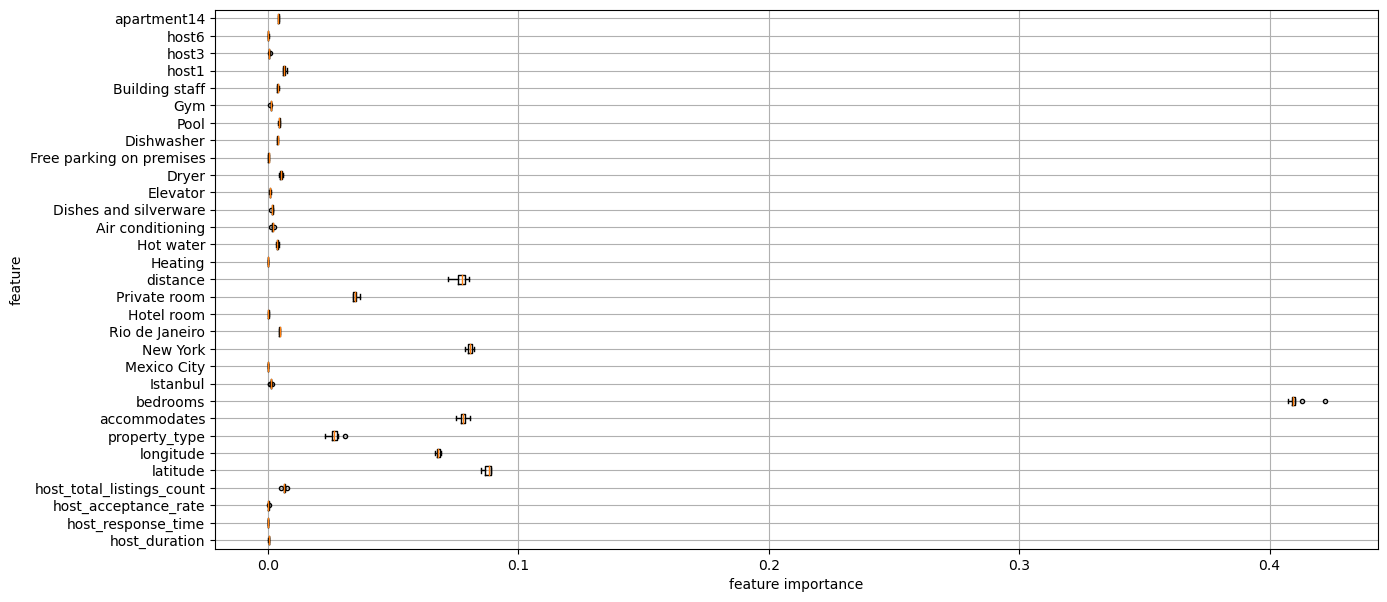

In [13]:
#select variables with a feature importance over 0.1%
feat_name_shuff_chose = feat_name[feat_import_value_shuff >= thresh]
feat_value_shuff_chose = shuff.importances[feat_import_value_shuff >= thresh].T

#visualize
fig,ax = plt.subplots(figsize=(15,7))
plt.rcParams['boxplot.flierprops.markersize'] = 3

ax.boxplot(feat_value_shuff_chose,vert=False)
ax.set_yticklabels(feat_name_shuff_chose)
ax.set_xlabel('feature importance')
ax.set_ylabel('feature')
ax.grid()
plt.show()

In [139]:
#extract the features that have passed the final selection
X_train = X_train[feat_name_shuff_chose]
X_test = X_test[feat_name_shuff_chose]

## Part Two: Model Training
The article titled "Why do tree-based models still outperform deep learning on tabular data?" on Arxiv tested 45 datasets from various domains and found that tree models perform better than neural networks for tabular data with sample sizes around 10k. Therefore, I will prioritize using tree models for training here.
### Model 1：Xgboost
#### Version 1.0：train it directly

In [164]:
X_train = pd.read_csv('.\\tmp\\X_train.csv',index_col=0)
X_test = pd.read_csv('.\\tmp\\X_test.csv',index_col=0)
Y_train = pd.read_csv('.\\tmp\\Y_train.csv',index_col=0)
Y_test = pd.read_csv('.\\tmp\\Y_test.csv',index_col=0)

In [7]:
#model traning
%%time
model1 = xgb.XGBRegressor(random_state=seed)
model1.fit(X_train,Y_train)
Y_pred1 = model1.predict(X_test)

CPU times: total: 10.1 s
Wall time: 2.34 s


In [8]:
#visualize the distribution
fig,ax = plt.subplots(figsize=(10,6))

ax.hist(Y_test,bins=200,density=True,label='True',alpha=0.7)
ax.hist(Y_pred1,bins=200,density=True,label='Predict',alpha=0.5)

ax.legend(loc='upper right')
ax.grid()

plt.show()

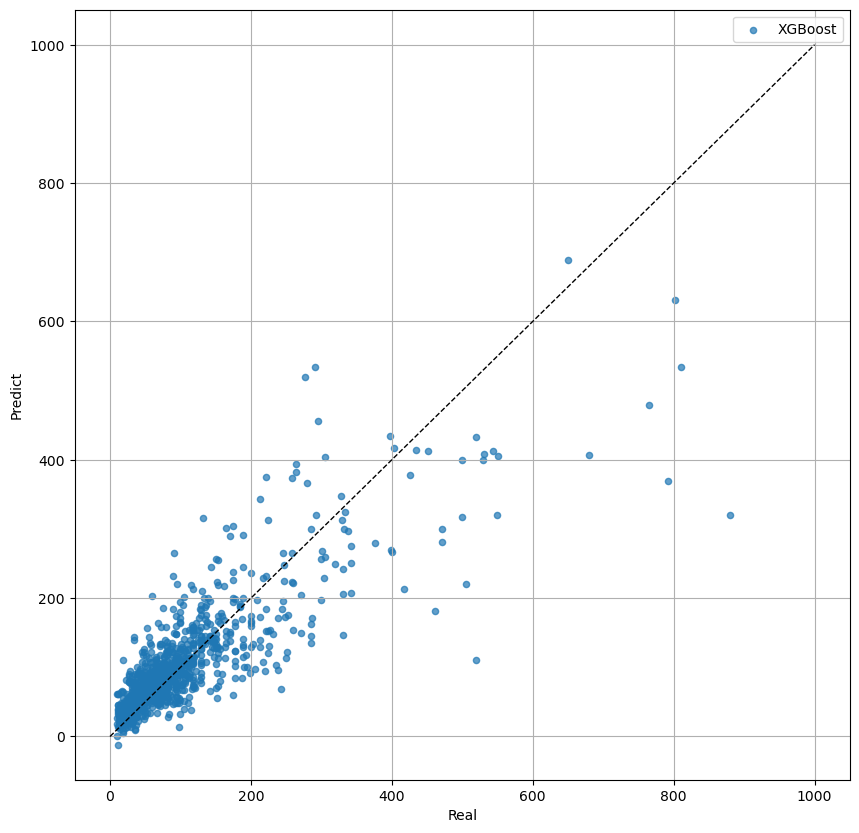

In [9]:
# plot the scatter
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(Y_test[0:1000], Y_pred1[0:1000], label='XGBoost', s=20, alpha=0.7)
ax.plot((0,1000),(0,1000), '--k', lw=1)

ax.set_xlabel('Real')
ax.set_ylabel('Predict')
ax.legend(loc='upper right')
ax.grid()

plt.show()

In [10]:
#calculate the RMSE
mean_squared_error(Y_test,Y_pred1,squared=False)

66.8947513670952

#### Version 2.0：log the target variable
From the visualization results, it's evident that Version 1.0 of the model may produce negative predictions, which is unacceptable in practice. Therefore, I applied a logarithmic transformation to ensure that the predicted results are positive values.

In [28]:
#log Y
Y_train_log = np.log(Y_train)
Y_test_log = np.log(Y_test)

In [12]:
#visualize the distribution
fig,ax = plt.subplots(2,1,figsize=(10,6))

ax[0].hist(Y_train,bins=100,density=True,label='True',alpha=0.7)
ax[1].hist(Y_train_log,bins=100,density=True,label='Predict',alpha=0.7)

ax[0].set_title('Before log')
ax[1].set_title('After log')

ax[0].grid()
ax[1].grid()

plt.show()

In [13]:
#model training
%%time
model2 = xgb.XGBRegressor(random_state=seed)
model2.fit(X_train,Y_train_log)
Y_pred_log2 = model2.predict(X_test)
Y_pred2 = np.exp(Y_pred_log2) #exp them back in the currency unit

CPU times: total: 11.2 s
Wall time: 2.49 s


In [14]:
#visualize the distribution, no negative value this time
fig,ax = plt.subplots(figsize=(10,6))

ax.hist(Y_test,bins=200,density=True,label='True',alpha=0.7)
ax.hist(Y_pred2,bins=200,density=True,label='Predict',alpha=0.5)

ax.legend(loc='upper right')
ax.grid()

plt.show()

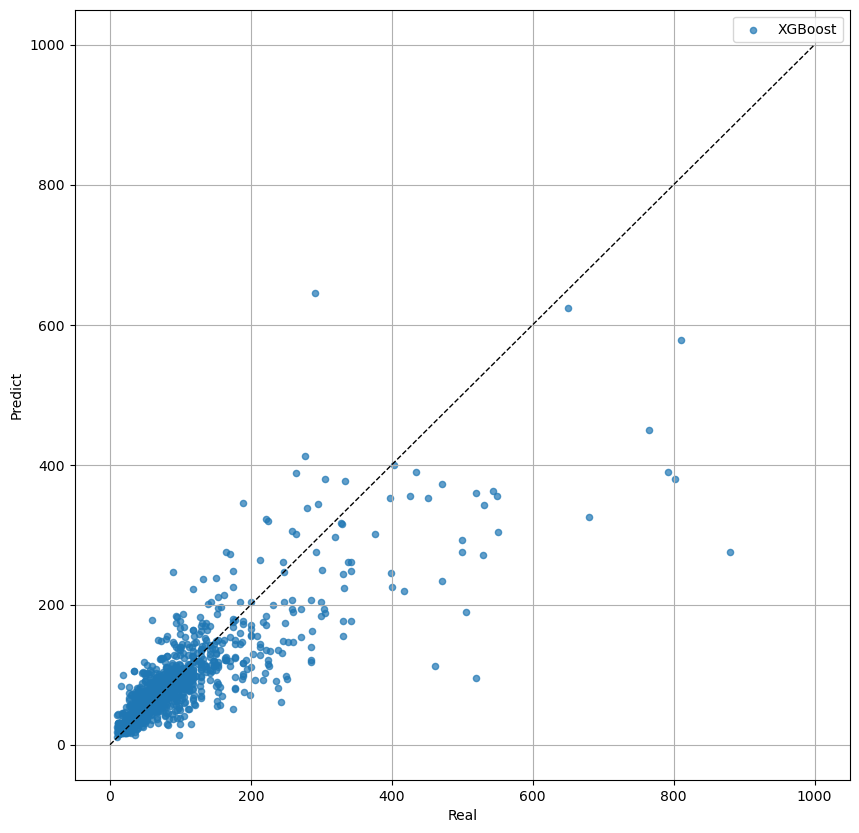

In [15]:
#plot the scatter
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(Y_test[0:1000], Y_pred2[0:1000], label='XGBoost', s=20, alpha=0.7)
ax.plot((0,1000),(0,1000), '--k', lw=1)

ax.set_xlabel('Real')
ax.set_ylabel('Predict')
ax.legend(loc='upper right')
ax.grid()

plt.show()

In [16]:
#calculate the RMSE
mean_squared_error(Y_test,Y_pred2,squared=False)

68.98384116085104

#### Version 3.0:Use Optuna for hyperparameter tuning.
Previously, I used the default hyperparameters for the model. Now, I will use the Optuna framework to perform hyperparameter optimization. Optuna utilizes Bayesian optimization to efficiently tune the model's parameters, which is more efficient compared to methods like GridSearchCV that rely on approximate exhaustive search algorithms.

In [17]:
def objective(trial):
    '''
    params：
    eta:learning rate
    subsample:the proportion of the subsample
    colsample_bytree：the proportion of features used in each decision tree
    max_depth：the maximum depth of each decision tree
    alpha：L1 regularization
    lambda：L2 regularization
    gamma：the minimum loss reduction required to further split a node
    min_child_weight：the minimum number of instances required to split a node
    '''
    params = {'eta':trial.suggest_float('eta',0.0,1.0),
              'subsample':trial.suggest_float('subsample',0.0,1.0,step=0.1),
              'colsample_bytree':trial.suggest_float('colsample_bytree', 0.0, 1.0,step=0.1),
              'max_depth': trial.suggest_int('max_depth',3,20),
              'alpha':trial.suggest_float('alpha', 1e-3,1e3,log=True),
              'lambda':trial.suggest_float('lambda',1e-3,1e3,log=True),
              'gamma':trial.suggest_float('gamma',1e-3,1e3,log=True),
              'min_child_weight':trial.suggest_int('min_child_weight', 1,100),
              'random_state':seed}
    model3 = xgb.XGBRegressor(**params)
    model3.fit(X_train,Y_train_log)
    Y_pred_log3 = model3.predict(X_test)
    Y_pred3 = np.exp(Y_pred_log3)
    rmse = mean_squared_error(Y_test,Y_pred3, squared=False) #use RMSE of test subset as the target function
    return rmse

Once the Optuna setup is completed, tuning can be initiated. Optuna will display each tuning result in the form of logs. Since XGBoost has many hyperparameters to tune, the iteration may take some time.

In [18]:
#number of iterations
n_trials = 200

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

#output the tuned results
print('Number of finished trials:', len(study.trials))
print("------------------------------------------------")
print('Best trial:', study.best_trial.params)
print("------------------------------------------------")
print(study.trials_dataframe())
print("------------------------------------------------")

[I 2023-12-25 11:20:55,107] A new study created in memory with name: no-name-41bd6347-842f-44f1-9c93-54ccd8e9a3c4
[I 2023-12-25 11:20:58,117] Trial 0 finished with value: 79.28781581410912 and parameters: {'eta': 0.06468019437800243, 'subsample': 1.0, 'colsample_bytree': 0.4, 'max_depth': 17, 'alpha': 538.429192714475, 'lambda': 0.013131949176885666, 'gamma': 0.010223427804730187, 'min_child_weight': 61}. Best is trial 0 with value: 79.28781581410912.
[I 2023-12-25 11:21:00,318] Trial 1 finished with value: 76.6300478650889 and parameters: {'eta': 0.9905251552234741, 'subsample': 0.2, 'colsample_bytree': 0.0, 'max_depth': 11, 'alpha': 0.4708209123275019, 'lambda': 7.345252121452132, 'gamma': 0.8773584716506195, 'min_child_weight': 68}. Best is trial 1 with value: 76.6300478650889.
[I 2023-12-25 11:21:04,695] Trial 2 finished with value: 71.41358186637213 and parameters: {'eta': 0.11452996995051834, 'subsample': 1.0, 'colsample_bytree': 0.30000000000000004, 'max_depth': 13, 'alpha': 0.0

Number of finished trials: 200
------------------------------------------------
Best trial: {'eta': 0.19746206571899852, 'subsample': 0.9, 'colsample_bytree': 0.8, 'max_depth': 16, 'alpha': 2.245467538172984, 'lambda': 1.273307804855162, 'gamma': 0.004620564984733545, 'min_child_weight': 18}
------------------------------------------------
     number      value             datetime_start          datetime_complete  \
0         0  79.287816 2023-12-25 11:20:55.109731 2023-12-25 11:20:58.116050   
1         1  76.630048 2023-12-25 11:20:58.120049 2023-12-25 11:21:00.317776   
2         2  71.413582 2023-12-25 11:21:00.320775 2023-12-25 11:21:04.694105   
3         3  67.503246 2023-12-25 11:21:04.697108 2023-12-25 11:21:08.863081   
4         4  68.400812 2023-12-25 11:21:08.865081 2023-12-25 11:21:12.324791   
..      ...        ...                        ...                        ...   
195     195  73.312893 2023-12-25 11:47:57.801963 2023-12-25 11:48:01.530527   
196     196  66.24

In [195]:
%%time
xgb_parama = study.best_trial.params #use the best params from optuna
XGB = xgb.XGBRegressor(**xgb_parama,random_state=seed)

XGB.fit(X_train,Y_train_log)
Y_pred_log3 = XGB.predict(X_test)
Y_pred3 = np.exp(Y_pred_log3)

CPU times: total: 48.9 s
Wall time: 11.5 s


In [20]:
#visualize the distribution
fig,ax = plt.subplots(figsize=(10,6))

ax.hist(Y_test,bins=200,density=True,label='True',alpha=0.7)
ax.hist(Y_pred3,bins=200,density=True,label='Predict',alpha=0.5)

ax.legend(loc='upper right')
ax.grid()

plt.show()

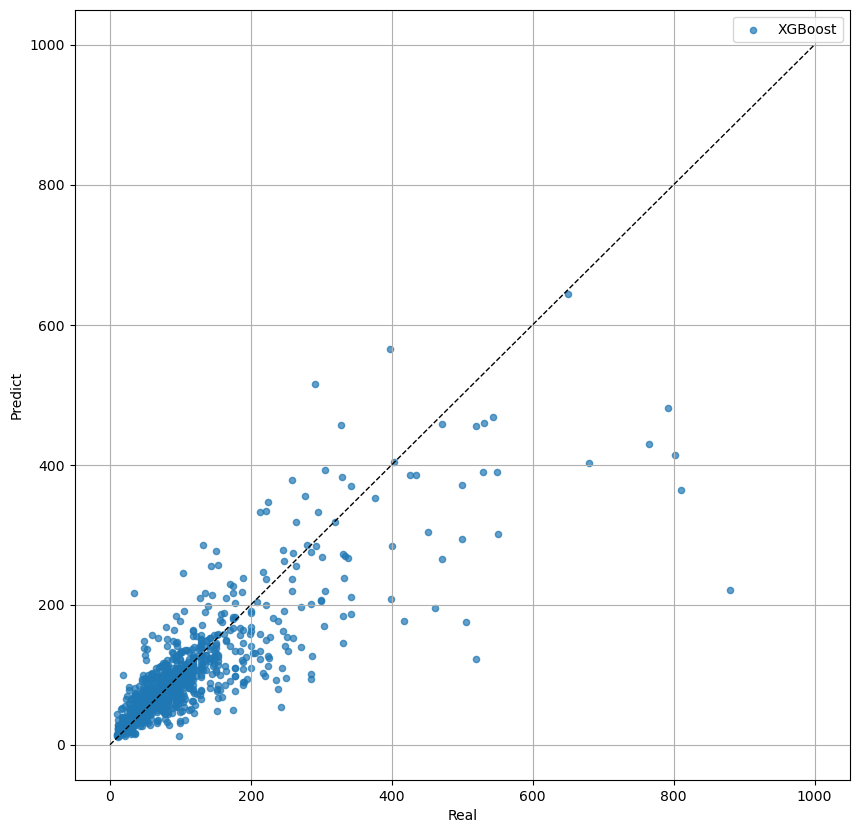

In [21]:
#plot the scatter
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(Y_test[0:1000], Y_pred3[0:1000], label='XGBoost', s=20, alpha=0.7)
ax.plot((0,1000),(0,1000), '--k', lw=1)

ax.set_xlabel('Real')
ax.set_ylabel('Predict')
ax.legend(loc='upper right')
ax.grid()

plt.show()

In [22]:
#calculate the RMSE,the performance has improved significantly
mean_squared_error(Y_test,Y_pred3,squared=False)

65.80323430694047

I've completed the training and optimization of XGBoost.From now on, I will proceed directly to the final model without intermediate versions.

### Model 2：Adaboost
AdaBoost is also a boosting tree model, but its principle differs significantly from XGBoost. AdaBoost focuses on amplifying the weights of misclassified instances in subsequent weak learners' training to enhance model performance.

In [187]:
def objective1(trial):
    '''
    n_estimators：total number of submodels
    learning_rate：learning rate
    '''
    params = {'n_estimators':trial.suggest_int('n_estimators',50,500,step=50),
              'learning_rate':trial.suggest_float('learning_rate',0.05,1.0,step=0.05),
              'random_state':seed}
    Ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=3),**params)
    Ada.fit(X_train,np.array(Y_train_log).reshape(-1))
    Y_pred_log4 = Ada.predict(X_test)
    Y_pred4 = np.exp(Y_pred_log4)
    rmse = mean_squared_error(Y_test,Y_pred4, squared=False)
    return rmse

In [188]:
#number of iterations
n_trials = 20

study1 = optuna.create_study(direction='minimize')
study1.optimize(objective1, n_trials=n_trials)

#output the tuned results
print('Number of finished trials:', len(study1.trials))
print("------------------------------------------------")
print('Best trial:', study1.best_trial.params)
print("------------------------------------------------")
print(study1.trials_dataframe())
print("------------------------------------------------")

[I 2024-01-07 03:55:38,098] A new study created in memory with name: no-name-abda5ba8-5fa1-4ecf-b4b3-af3cc837dccb
[I 2024-01-07 03:56:26,099] Trial 0 finished with value: 88.30221325873578 and parameters: {'n_estimators': 400, 'learning_rate': 0.9000000000000001}. Best is trial 0 with value: 88.30221325873578.
[I 2024-01-07 03:58:05,893] Trial 1 finished with value: 88.76936200022614 and parameters: {'n_estimators': 50, 'learning_rate': 0.15000000000000002}. Best is trial 0 with value: 88.30221325873578.
[I 2024-01-07 03:59:04,102] Trial 2 finished with value: 89.04187767034756 and parameters: {'n_estimators': 300, 'learning_rate': 0.6500000000000001}. Best is trial 0 with value: 88.30221325873578.
[I 2024-01-07 03:59:46,864] Trial 3 finished with value: 88.65674250009086 and parameters: {'n_estimators': 50, 'learning_rate': 0.8}. Best is trial 0 with value: 88.30221325873578.
[I 2024-01-07 04:01:33,400] Trial 4 finished with value: 88.42199732168633 and parameters: {'n_estimators': 40

Number of finished trials: 20
------------------------------------------------
Best trial: {'n_estimators': 50, 'learning_rate': 0.25}
------------------------------------------------
    number      value             datetime_start          datetime_complete  \
0        0  88.302213 2024-01-07 03:55:38.099641 2024-01-07 03:56:26.099191   
1        1  88.769362 2024-01-07 03:56:26.101193 2024-01-07 03:58:05.893449   
2        2  89.041878 2024-01-07 03:58:05.895738 2024-01-07 03:59:04.102511   
3        3  88.656743 2024-01-07 03:59:04.118635 2024-01-07 03:59:46.863649   
4        4  88.421997 2024-01-07 03:59:46.865648 2024-01-07 04:01:33.400352   
5        5  89.580269 2024-01-07 04:01:33.400352 2024-01-07 04:03:22.003262   
6        6  88.302213 2024-01-07 04:03:22.003262 2024-01-07 04:04:12.293066   
7        7  88.011115 2024-01-07 04:04:12.293066 2024-01-07 04:05:46.325982   
8        8  89.116015 2024-01-07 04:05:46.325982 2024-01-07 04:06:24.557303   
9        9  88.429546 2024

In [190]:
%%time
Ada_parama = study1.best_trial.params #use the best params from optuna
Ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=3),**Ada_parama)
Ada.fit(X_train,np.array(Y_train_log).reshape(-1))
Y_pred_log4 = Ada.predict(X_test)
Y_pred4 = np.exp(Y_pred_log4)
rmse = mean_squared_error(Y_test,Y_pred4, squared=False)

CPU times: total: 48.7 s
Wall time: 1min 34s


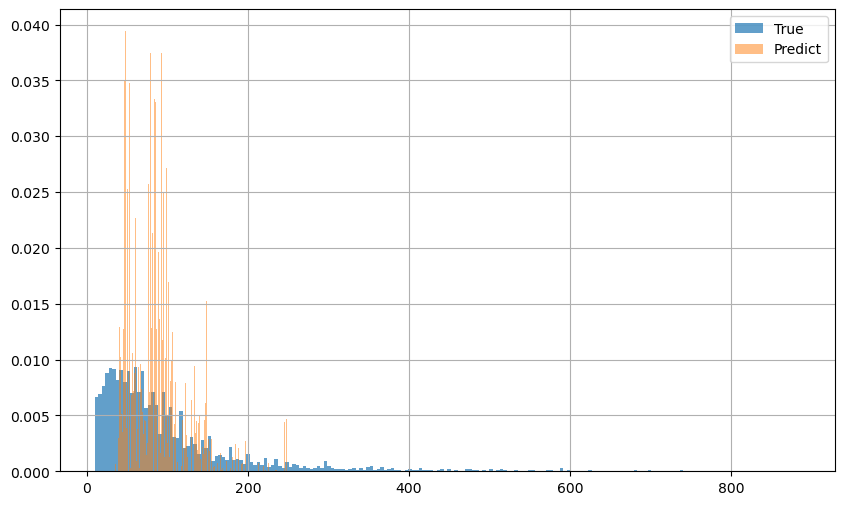

In [191]:
#visualize the distribution
fig,ax = plt.subplots(figsize=(10,6))

ax.hist(Y_test,bins=200,density=True,label='True',alpha=0.7)
ax.hist(Y_pred4,bins=200,density=True,label='Predict',alpha=0.5)

ax.legend(loc='upper right')
ax.grid()

plt.show()

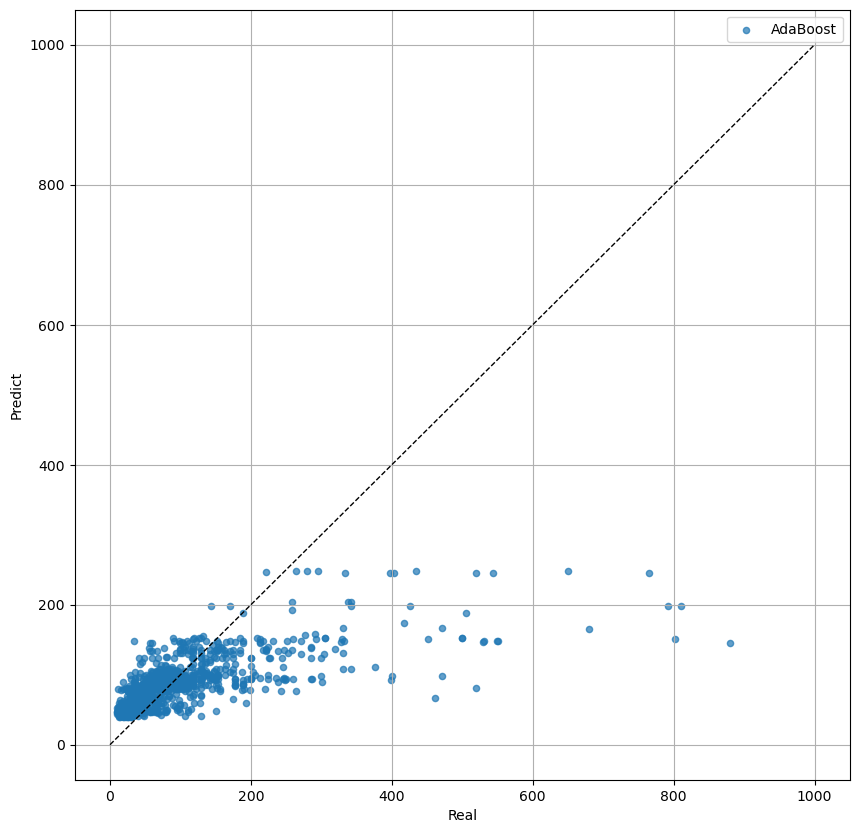

In [192]:
# scatter the plot
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(Y_test[0:1000], Y_pred4[0:1000], label='AdaBoost', s=20, alpha=0.7)
ax.plot((0,1000),(0,1000), '--k', lw=1)

ax.set_xlabel('Real')
ax.set_ylabel('Predict')
ax.legend(loc='upper right')
ax.grid()

plt.show()

In [193]:
Y_pred_log4 = Ada.predict(X_test)
Y_pred4 = np.exp(Y_pred_log4)
rmse1 = mean_squared_error(Y_test,Y_pred4, squared=False)
rmse2 = mean_squared_error(Y_train,np.exp(Ada.predict(X_train)), squared=False)
print(rmse1) #RMSE of test subset
print(rmse2) #RMSE of train subset

88.4715902461296
88.70594645538826


Based on the visualization results, it can be observed that AdaBoost struggles to predict high house prices, as its predicted values are consistently below 300.

### Model 3：Random Forest

In [182]:
def objective2(trial):
    '''
    n_estimators:total number of submodels
    max_depth:maximum layers in each dicision tree
    '''
    params = {'n_estimators':trial.suggest_int('n_estimators',50,500,step=50),
              'max_depth':trial.suggest_int('max_depth',2,10),
              'random_state':seed,
              'n_jobs':-1}
    forest = RandomForestRegressor(**params)
    forest.fit(X_train,np.array(Y_train_log).reshape(-1))
    Y_pred_log5 = forest.predict(X_test)
    Y_pred5 = np.exp(Y_pred_log5)
    rmse = mean_squared_error(Y_test,Y_pred5, squared=False)
    return rmse

In [183]:
#number of iteration
n_trials = 20

study2 = optuna.create_study(direction='minimize')
study2.optimize(objective2, n_trials=n_trials)

#output the tuned results
print('Number of finished trials:', len(study2.trials))
print("------------------------------------------------")
print('Best trial:', study2.best_trial.params)
print("------------------------------------------------")
print(study2.trials_dataframe())
print("------------------------------------------------")

[I 2024-01-07 02:37:41,985] A new study created in memory with name: no-name-28ec9ff5-e88e-4447-bd06-52109872eb22
[I 2024-01-07 02:38:39,560] Trial 0 finished with value: 92.23927123490601 and parameters: {'n_estimators': 300, 'max_depth': 3}. Best is trial 0 with value: 92.23927123490601.
[I 2024-01-07 02:38:46,558] Trial 1 finished with value: 95.9045790731297 and parameters: {'n_estimators': 50, 'max_depth': 2}. Best is trial 0 with value: 92.23927123490601.
[I 2024-01-07 02:39:19,538] Trial 2 finished with value: 85.63096212985137 and parameters: {'n_estimators': 100, 'max_depth': 5}. Best is trial 2 with value: 85.63096212985137.
[I 2024-01-07 02:41:28,031] Trial 3 finished with value: 78.49903864740865 and parameters: {'n_estimators': 250, 'max_depth': 8}. Best is trial 3 with value: 78.49903864740865.
[I 2024-01-07 02:43:04,027] Trial 4 finished with value: 85.61120390389576 and parameters: {'n_estimators': 300, 'max_depth': 5}. Best is trial 3 with value: 78.49903864740865.
[I 

Number of finished trials: 20
------------------------------------------------
Best trial: {'n_estimators': 400, 'max_depth': 10}
------------------------------------------------
    number      value             datetime_start          datetime_complete  \
0        0  92.239271 2024-01-07 02:37:41.987793 2024-01-07 02:38:39.560952   
1        1  95.904579 2024-01-07 02:38:39.562953 2024-01-07 02:38:46.557822   
2        2  85.630962 2024-01-07 02:38:46.559809 2024-01-07 02:39:19.537155   
3        3  78.499039 2024-01-07 02:39:19.539115 2024-01-07 02:41:28.030670   
4        4  85.611204 2024-01-07 02:41:28.032680 2024-01-07 02:43:04.027486   
5        5  95.905857 2024-01-07 02:43:04.027486 2024-01-07 02:43:29.088250   
6        6  85.611204 2024-01-07 02:43:29.089260 2024-01-07 02:45:05.204736   
7        7  80.382803 2024-01-07 02:45:05.206657 2024-01-07 02:47:18.895946   
8        8  82.840081 2024-01-07 02:47:18.896937 2024-01-07 02:49:56.039137   
9        9  75.277729 2024-01-0

In [184]:
%%time
forest_parama = study2.best_trial.params #use the best params from optuna
forest = RandomForestRegressor(**forest_parama,random_state=seed,n_jobs=-1)
forest.fit(X_train,np.array(Y_train_log).reshape(-1))
Y_pred_log5 = forest.predict(X_test)
Y_pred5 = np.exp(Y_pred_log5)
rmse = mean_squared_error(Y_test,Y_pred5, squared=False) #calculate RMSE
print(rmse)

75.27772899996873
CPU times: total: 29min 24s
Wall time: 4min 11s


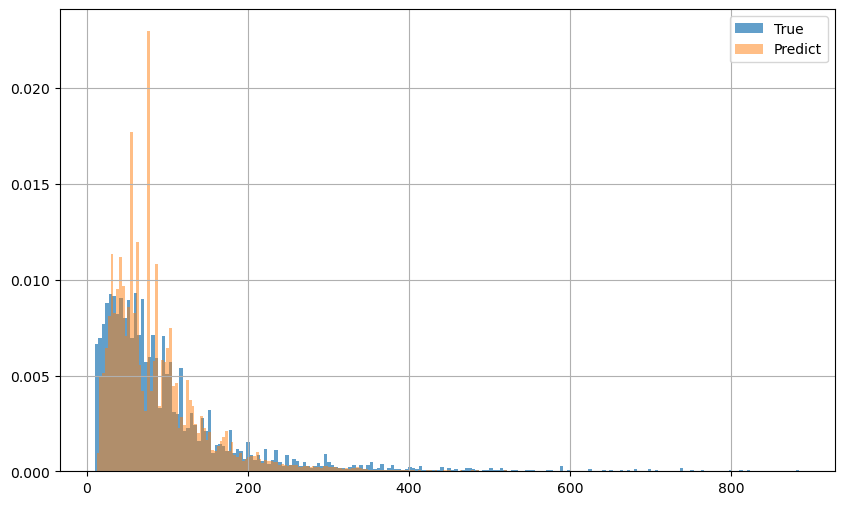

In [185]:
#visualize the distribution
fig,ax = plt.subplots(figsize=(10,6))

ax.hist(Y_test,bins=200,density=True,label='True',alpha=0.7)
ax.hist(Y_pred5,bins=200,density=True,label='Predict',alpha=0.5)

ax.legend(loc='upper right')
ax.grid()

plt.show()

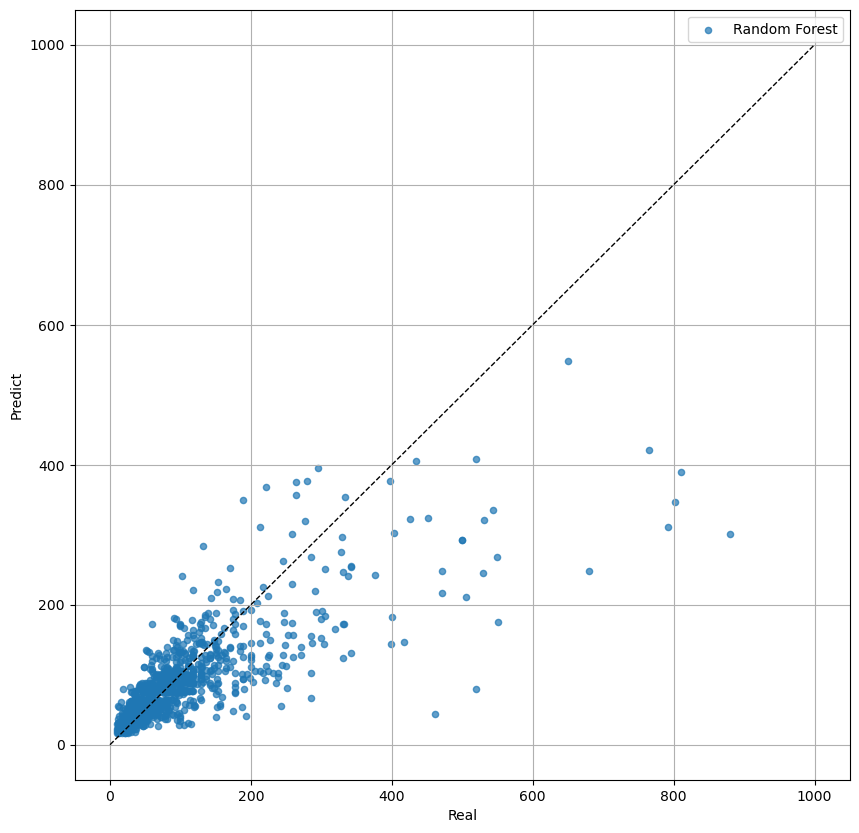

In [186]:
#plot the scatter
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(Y_test[0:1000], Y_pred5[0:1000], label='Random Forest', s=20, alpha=0.7)
ax.plot((0,1000),(0,1000), '--k', lw=1)

ax.set_xlabel('Real')
ax.set_ylabel('Predict')
ax.legend(loc='upper right')
ax.grid()

plt.show()

### Model 4：Stacking
Above, multiple tree models were trained. To further improve model performance, I attempted to use stacking.</br>
Due to the poor prediction performance of AdaBoost (high RMSE, significant bias), I only used XGBoost and RandomForest as base models for stacking.

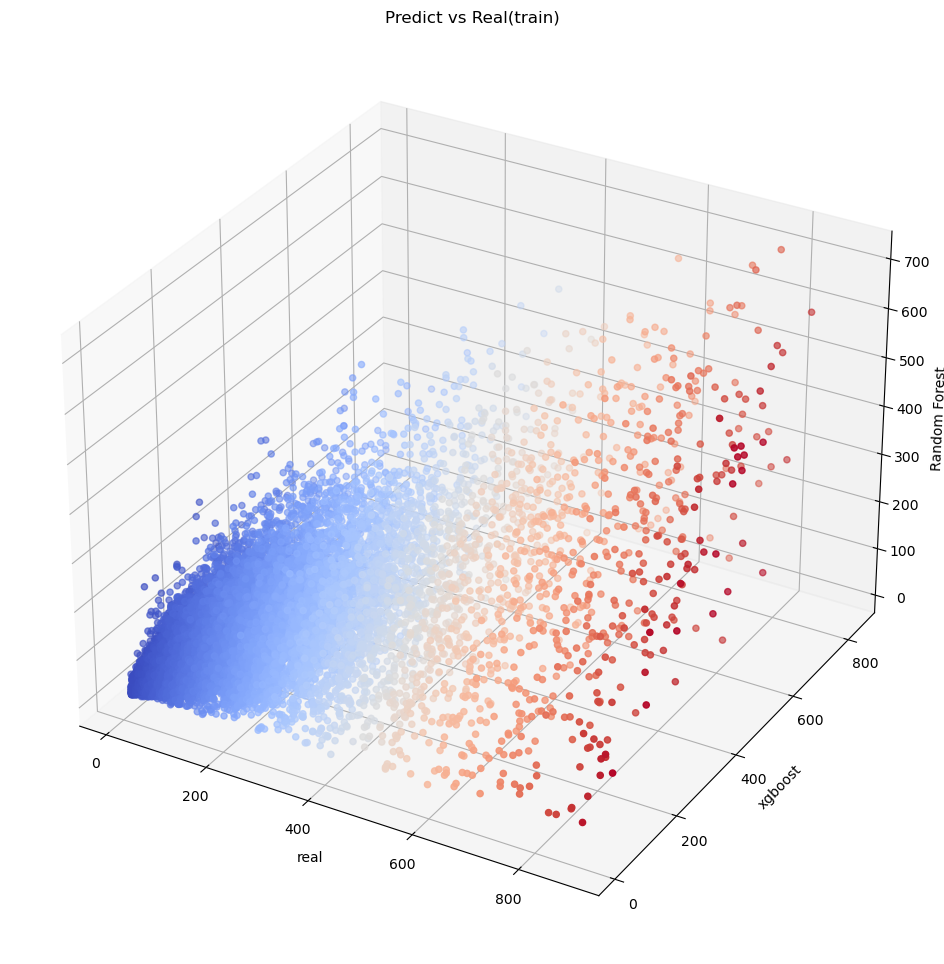

In [197]:
#visualize the result based on RF and Xgboost
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(Y_test,Y_pred3,Y_pred5,c=Y_test,cmap='coolwarm')
ax.set_xlabel('real')
ax.set_ylabel('xgboost')
ax.set_zlabel('Random Forest')
ax.set_title('Predict vs Real(train)')
plt.show()

The basic idea of stacking is to have multiple base models make independent predictions in the first layer, and then input the predictions of these base models into a simpler model in the second layer to obtain the final predictions of the entire model.</br>
From the visualization results mentioned above, it seems that the true values, XGBoost predictions, and RandomForest predictions are distributed on some three-dimensional surface. Therefore, there is reason to believe that stacking may help improve model performance.

In [198]:
class MyStacking:
    # initialize model parameters
    def __init__(self, estimators, final_estimator, cv=6, method='predict'):
        self.cv = cv
        self.method = method
        self.estimators = estimators
        self.final_estimator = final_estimator

    # model training
    def fit(self,X,Y):
        # primary output
        dataset_train = self.stacking(X,Y)

        # model stacking
        self.final_estimator.fit(dataset_train,Y)

    # output of stacking
    def stacking(self,X,Y):
        kf = KFold(n_splits=self.cv, shuffle=True, random_state=111)
        # primary output
        dataset_train = np.zeros((X.shape[0], len(self.estimators)))
        for i, model in enumerate(self.estimators):
            for (train, val) in kf.split(X,Y):
                X_train = X.iloc[train]
                X_val = X.iloc[val]
                Y_train = Y[train]
                Y_val_pred = model.fit(X_train,Y_train).predict(X_val)
                dataset_train[val, i] = Y_val_pred
            self.estimators[i] = model
        #input the primary output into a fifth-order polynomial regressor to obtain a secondary output
        dataset_train = PolynomialFeatures(degree=5).fit_transform(dataset_train)
        return dataset_train

    # model forcasting
    def predict(self, X):
        datasets_test = np.zeros((X.shape[0], len(self.estimators)))
        #primary output
        for i, model in enumerate(self.estimators):
            datasets_test[:, i] = model.predict(X)
        #secondary output
        datasets_test = PolynomialFeatures(degree=5).fit_transform(datasets_test)

        return self.final_estimator.predict(datasets_test)

    # model metrics
    def rmse(self,X,Y):
        datasets_test = np.zeros((X.shape[0], len(self.estimators)))
        #primary output
        for i, model in enumerate(self.estimators):
            datasets_test[:, i] = model.predict(X)
        #secondary output
        datasets_test = PolynomialFeatures(degree=5).fit_transform(datasets_test)
        Y_pred = self.final_estimator.predict(datasets_test)
        rmse = mean_squared_error(np.exp(Y_pred),np.exp(Y), squared=False)
        return rmse

In [199]:
%%time
XGB1 = XGB
forest1 = forest
estimators = [XGB1,forest1]

final = MyStacking(estimators=estimators,final_estimator=LinearRegression())

final.fit(X_train, np.array(Y_train_log).reshape(-1))

print(final.rmse(X_train, np.array(Y_train_log).reshape(-1)))
print(final.rmse(X_test, np.array(Y_test_log).reshape(-1)))

51.03234031244394
66.4762629073888
CPU times: total: 2h 33min 2s
Wall time: 22min 3s


In [200]:
#predict with the trained model
Y_pred6_log = final.predict(X_test)
Y_pred6 = np.exp(Y_pred6_log)

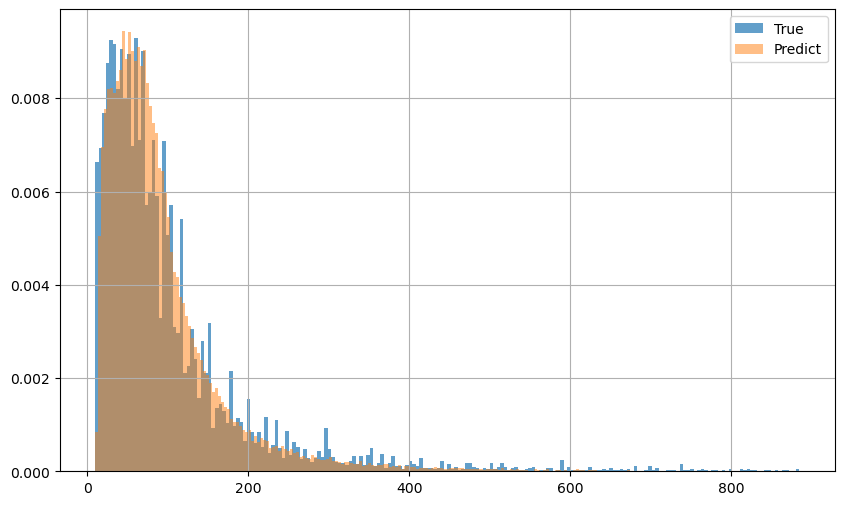

In [201]:
#visualize the distribution
fig,ax = plt.subplots(figsize=(10,6))

ax.hist(Y_test,bins=200,density=True,label='True',alpha=0.7)
ax.hist(Y_pred6,bins=200,density=True,label='Predict',alpha=0.5)

ax.legend(loc='upper right')
ax.grid()

plt.show()

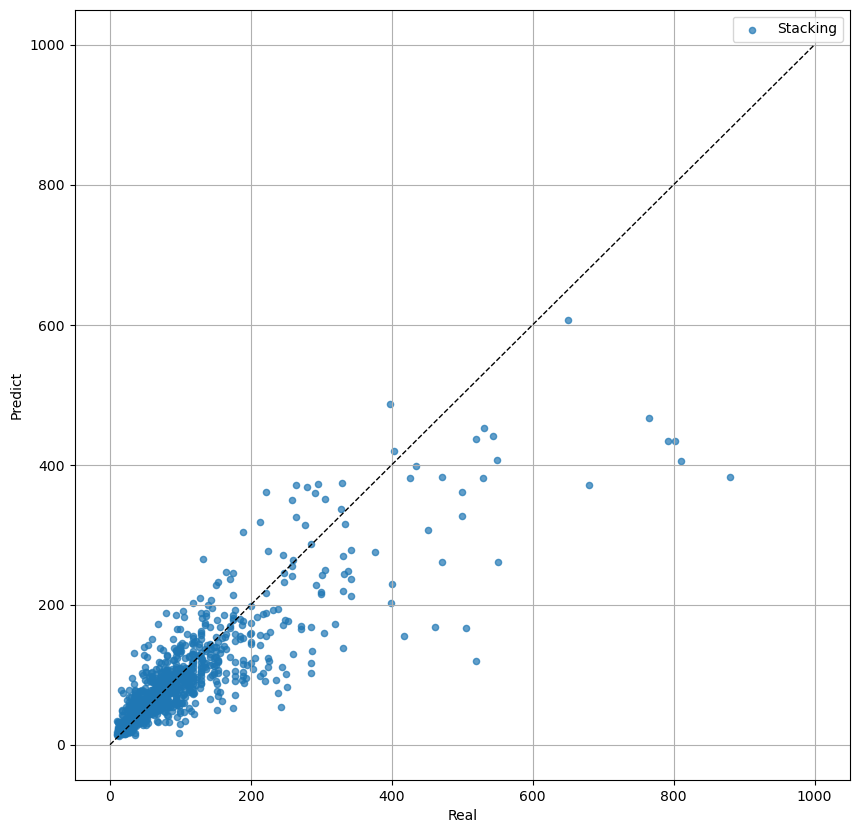

In [202]:
#plot the scatter
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(Y_test[0:1000], Y_pred6[0:1000], label='Stacking', s=20, alpha=0.7)
ax.plot((0,1000),(0,1000), '--k', lw=1)

ax.set_xlabel('Real')
ax.set_ylabel('Predict')
ax.legend(loc='upper right')
ax.grid()

plt.show()

## Part Three: Results
#### One.RMSE
I have separately calculated the in-sample, 6-fold cross-validation, and out-of-sample RMSE for each of the previous models. Here, I have also calculated the out-of-sample MAE for each model.

In [23]:
#Construct the table
model_names = ['Xgboost', 'Adaboost','Random Forest','Stacking']
metrics_names = ['In sample', 'Cross-validation', 'Testing','Total N of Predictions after dropping outliers','MAE']
perf = pd.DataFrame(index=model_names, columns=metrics_names)

In [25]:
#Xgboost
Y_pred11 = np.exp(XGB.predict(X_train))
Y_pred12 = np.exp(XGB.predict(X_test))
perf['In sample']['Xgboost'] = mean_squared_error(Y_train,Y_pred11, squared=False) #in sample
perf['Cross-validation']['Xgboost'] = np.sqrt(-cross_val_score(XGB,X_train,Y_train,cv = 6, scoring='neg_mean_squared_error')).mean() #6 fold cv
perf['Testing']['Xgboost'] = mean_squared_error(Y_test,Y_pred12, squared=False) #out of sample
perf['Total N of Predictions after dropping outliers']['Xgboost'] = len(X_test) #sample size
perf['MAE']['Xgboost'] = mean_absolute_error(Y_test,Y_pred12) #MAE (out of sample)

In [54]:
#Adaboost
Y_pred21 = np.exp(Ada.predict(X_train))
Y_pred22 = np.exp(Ada.predict(X_test))
perf['In sample']['Adaboost'] = mean_squared_error(Y_train,Y_pred21, squared=False) #in sample
#6 fold cv
perf['Cross-validation']['Adaboost'] = np.sqrt(-cross_val_score(Ada,X_train,np.array(Y_train).reshape(-1)
                                                                ,cv = 6, scoring='neg_mean_squared_error')).mean()
perf['Testing']['Adaboost'] = mean_squared_error(Y_test,Y_pred22, squared=False) #out of sample
perf['Total N of Predictions after dropping outliers']['Adaboost'] = len(X_test) #sample size
perf['MAE']['Adaboost'] = mean_absolute_error(Y_test,Y_pred22) #MAE (out of sample)

In [65]:
#Random Forest
Y_pred31 = np.exp(forest.predict(X_train))
Y_pred32 = np.exp(forest.predict(X_test))
perf['In sample']['Random Forest'] = mean_squared_error(Y_train,Y_pred31, squared=False) #in sample
#6 folds cv
perf['Cross-validation']['Random Forest'] = np.sqrt(-cross_val_score(forest,X_train,np.array(Y_train).reshape(-1)
                                                                     ,cv = 6, scoring='neg_mean_squared_error')).mean()
perf['Testing']['Random Forest'] = mean_squared_error(Y_test,Y_pred32, squared=False) #out of sample
perf['Total N of Predictions after dropping outliers']['Random Forest'] = len(X_test) #sample size
perf['MAE']['Random Forest'] = mean_absolute_error(Y_test,Y_pred32) #MAE(out of sample)

In [100]:
#Stacking
Y_pred41 = np.exp(final.predict(X_train))
Y_pred42 = np.exp(final.predict(X_test))
perf['In sample']['Stacking'] = mean_squared_error(Y_train,Y_pred41, squared=False) #in sample
perf['Testing']['Stacking'] = mean_squared_error(Y_test,Y_pred42, squared=False) #out of sample
perf['Total N of Predictions after dropping outliers']['Stacking'] = len(X_test) #sample size
perf['MAE']['Stacking'] = mean_absolute_error(Y_test,Y_pred42) #MAE(out of sample)

In [102]:
#6 folds cv
%%time
cv_rmse = 0
kf = KFold(n_splits=6)
#Validate each fold separately
for (train,val) in kf.split(X_train,Y_train_log):
    Xtrain = X_train.iloc[train]
    Ytrain = Y_train_log.iloc[train]
    Xval = X_train.iloc[val]
    Yval = Y_train.iloc[val]
    final.fit(Xtrain,np.array(Ytrain).reshape(-1))
    Y_tmp = np.exp(final.predict(Xval))
    cv_rmse += (mean_squared_error(Yval,Y_tmp, squared=False))/6
    print('Finish!')
    
perf['Cross-validation']['Stacking'] = cv_rmse

Finish!
Finish!
Finish!
Finish!
Finish!
Finish!
CPU times: total: 10h 1min 24s
Wall time: 1h 20min 31s


In [103]:
#print the performace
perf

In sample Cross-validation    Testing  \
Xgboost         46.02807        67.239403  65.803234   
Adaboost       88.459199       101.760656  88.348198   
Random Forest  73.833492        72.008984  75.263505   
Stacking       51.028487        67.663265  66.474601   

              Total N of Predictions after dropping outliers        MAE  
Xgboost                                                54807   32.97639  
Adaboost                                               54807  48.244254  
Random Forest                                          54807  38.727257  
Stacking                                               54807  33.347868

From the results, it's evident that XGBoost performs the best among all models.</br>
As for why Stacking's performance is not as good as XGBoost, I believe the reason lies in the fact that for Stacking to outperform base learners, it needs to satisfy at least two conditions: (1) there should be no significantly underperforming learners among the base learners, and (2) the base learners should complement each other's strengths.</br>
From the distribution plots, it can be seen that the prediction distributions of XGBoost and RandomForest are very similar. Therefore, they cannot complement each other's strengths, and thus fail to surpass the performance of XGBoost alone.</br>
(Note 1: The "Total N of Predictions after dropping outliers" mentioned here only includes the test set. The total number of predictions for the entire dataset is 5 times this value, i.e., 274,035.)</br>
(Note 2: There may be slight discrepancies in the results of AdaBoost and RandomForest compared to earlier due to an unsuccessful attempt to save the model midway through the process. The re-running of the previous program introduces randomness, but the error margin is kept within 1, which does not affect the final conclusion.)

#### Two.Feature Importance
I will calculate the importance of each feature in the best-performing XGBoost model. Here, I use the average permutation performance after shuffling to measure this.

In [203]:
#calculate permutation performance
%%time
shuff = permutation_importance(XGB,X_test,Y_test,n_repeats=5,n_jobs=-1,random_state=seed)
feat_import_value_shuff = shuff.importances_mean

CPU times: total: 11.1 s
Wall time: 1min 18s


In [215]:
Importance = pd.DataFrame({'feature':X_test.columns,
                        'importance':feat_import_value_shuff})
Importance = Importance.sort_values(by='importance',ascending=False)
Importance

feature  importance
4                    latitude    0.002474
8                    bedrooms    0.002428
7                accommodates    0.002366
5                   longitude    0.002087
15                   distance    0.001394
6               property_type    0.001282
11                   New York    0.001166
28                      host3    0.000496
3   host_total_listings_count    0.000458
9                    Istanbul    0.000389
0               host_duration    0.000348
21                      Dryer    0.000291
30                apartment14    0.000260
2        host_acceptance_rate    0.000251
24                       Pool    0.000224
23                 Dishwasher    0.000218
18           Air conditioning    0.000193
19      Dishes and silverware    0.000150
10                Mexico City    0.000148
16                    Heating    0.000143
17                  Hot water    0.000116
27                      host1    0.000105
12             Rio de Janeiro    0.000090
1          host_response_time    0.000052
20                   Elevator    0.000046
14               Private room    0.000043
13                 Hotel room    0.000030
25                        Gym    0.000025
26             Building staff    0.000017
29                      host6    0.000002
22   Free parking on premises   -0.000012

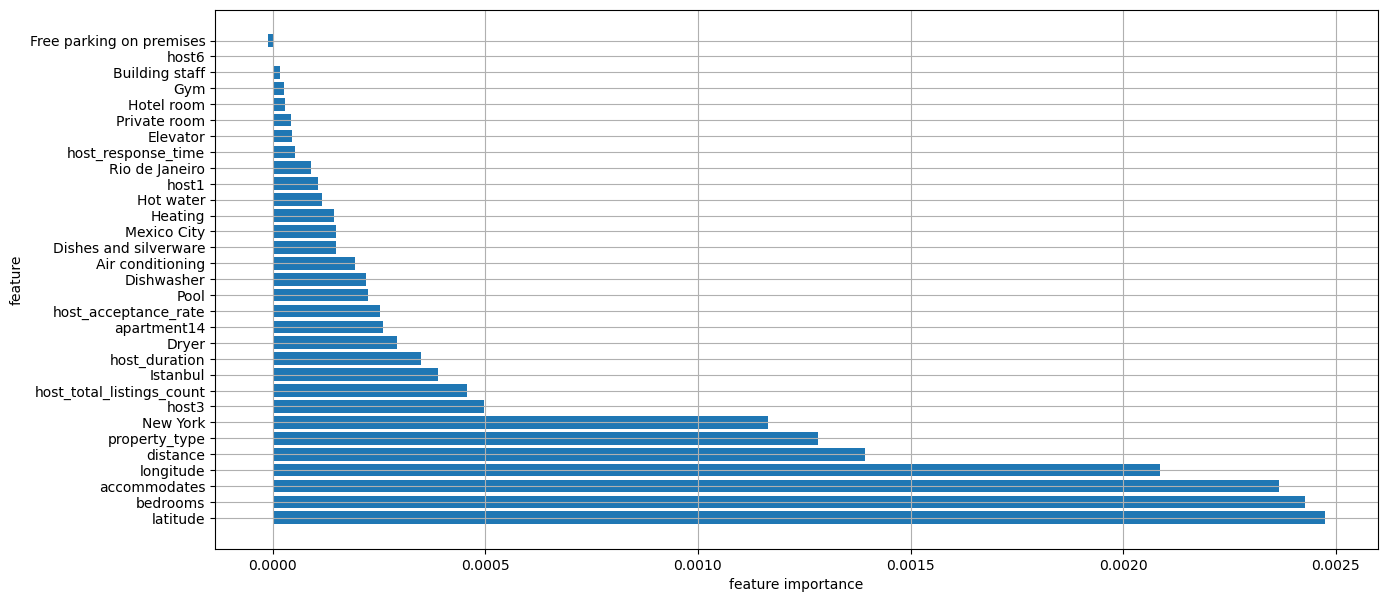

In [216]:
#visualize
fig,ax = plt.subplots(figsize=(15,7))
ax.barh(Importance['feature'],Importance['importance'])
ax.set_xlabel('feature importance')
ax.set_ylabel('feature')
ax.grid()
plt.show()

It's worth noting that the features we engineered ourselves, namely distance, host3, and apartment14, all rank relatively high in terms of feature importance.

### （Updated）Model 5：ANN
In the part above, we primarily used tree-based models. Now, let's try using another important class of algorithms in machine learning—artificial neural networks (ANN)—to predict house prices.

In [222]:
#split the dataset
X_train1,X_valid,Y_train_log1,Y_valid = train_test_split(X_train,Y_train_log,test_size=0.2,random_state=seed)
X_train = X_train.astype('float64')
X_train1 = X_train1.astype('float64')
X_valid = X_valid.astype('float64')
X_test = X_test.astype('float64')

In [110]:
#set RMSE as the objective function of ANN
def annrmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [130]:
#Optuna for tuning
def objective3(trial):
    '''
    params:
    'n_layers':numbers of hidden layers
    'n_units_li':numbers of nodes in ith hidden layer
    'lr':learning rate
    'weight_decay':decaying rate of learning rate
    '''
    #set up ANN
    n_layers = trial.suggest_int('n_layers',1,3)
    ann = tf.keras.Sequential()
    ann.add(tf.keras.layers.Flatten())
    for i in range(n_layers):
        num_hidden = trial.suggest_int(f'n_units_l{i}',10,100,step=10)
        ann.add(tf.keras.layers.Dense(num_hidden, activation='relu'))
    ann.add(tf.keras.layers.Dense(1))
    
    #set adam optimizer
    params = {'lr':trial.suggest_float('lr',0.0,0.2),
              'weight_decay':trial.suggest_float('weight_decay',0.0,0.1)}
    adam = keras.optimizers.Adam(**params)
     
    ann.compile(optimizer=adam,loss=annrmse)
    
    #set early stop to improve the efficiency
    callbacks = [keras.callbacks.EarlyStopping(patience = 5, min_delta = 1e-3),
                 optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]
    
    #model training
    ann.fit(X_train1,Y_train_log1,
            validation_data=(X_valid,Y_valid),
            epochs=50,callbacks = callbacks)
    Y_pred7_log = ann.predict(X_test)
    Y_pred7 = np.exp(Y_pred7_log)
    rmse = mean_squared_error(Y_test,Y_pred7, squared=False)
    
    return rmse

In [131]:
#numbers of iteration
n_trials = 50

study3 = optuna.create_study(direction='minimize')
study3.optimize(objective3, n_trials=n_trials)

#print the tuned result
print('Number of finished trials:', len(study3.trials))
print("------------------------------------------------")
print('Best trial:', study3.best_trial.params)
print("------------------------------------------------")
print(study3.trials_dataframe())
print("------------------------------------------------")

[I 2024-01-06 07:25:59,690] A new study created in memory with name: no-name-a3df8abe-3415-4570-9a60-aa4281ef17d7
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 20s 3ms/step - loss: 1.1418 - val_loss: 0.6067
Epoch 2/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.6117 - val_loss: 0.5732
Epoch 3/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.5895 - val_loss: 0.5601
Epoch 4/50
5481/5481 [==============================] - 21s 4ms/step - loss: 0.5790 - val_loss: 0.5535
Epoch 5/50
5481/5481 [==============================] - 20s 4ms/step - loss: 0.5790 - val_loss: 0.5527
Epoch 6/50
5481/5481 [==============================] - 19s 3ms/step - loss: 0.5766 - val_loss: 0.5716
Epoch 7/50
5481/5481 [==============================] - 19s 3ms/step - loss: 0.5754 - val_loss: 0.5959
Epoch 8/50
5481/5481 [==============================] - 21s 4ms/step - loss: 0.5713 - val_loss: 0.5589
Epoch 9/50
1713/1713 [==============================] - 4s 2ms/step


[I 2024-01-06 07:29:01,544] Trial 0 finished with value: 94.08801026863135 and parameters: {'n_layers': 3, 'n_units_l0': 50, 'n_units_l1': 40, 'n_units_l2': 60, 'lr': 0.040274394171412146, 'weight_decay': 0.08836738493451304}. Best is trial 0 with value: 94.08801026863135.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='v

Epoch 1/50
5481/5481 [==============================] - 19s 3ms/step - loss: 3.5704 - val_loss: 2.0382
Epoch 2/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.8714 - val_loss: 0.7006
Epoch 3/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.6534 - val_loss: 0.6375
Epoch 4/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.5965 - val_loss: 0.5782
Epoch 5/50
5481/5481 [==============================] - 20s 4ms/step - loss: 0.5789 - val_loss: 0.5567
Epoch 6/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.5722 - val_loss: 0.5757
Epoch 7/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5705 - val_loss: 0.5628
Epoch 8/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5693 - val_loss: 0.5461
Epoch 9/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5680 - val_loss: 0.5606
Epoch 10/50
5481/5481 [==============================] - 16s 3ms/step - l

[I 2024-01-06 07:32:55,742] Trial 1 finished with value: 99.9994702336789 and parameters: {'n_layers': 2, 'n_units_l0': 20, 'n_units_l1': 80, 'lr': 0.008061042055247403, 'weight_decay': 0.045747226454337944}. Best is trial 0 with value: 94.08801026863135.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=

Epoch 1/50
5481/5481 [==============================] - 21s 4ms/step - loss: 4.8311 - val_loss: 5.1988
Epoch 2/50
5481/5481 [==============================] - 16s 3ms/step - loss: 1.9526 - val_loss: 2.7743
Epoch 3/50
5481/5481 [==============================] - 16s 3ms/step - loss: 1.0756 - val_loss: 0.9741
Epoch 4/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.7873 - val_loss: 0.6394
Epoch 5/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.6767 - val_loss: 0.6102
Epoch 6/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.6161 - val_loss: 0.5634
Epoch 7/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5823 - val_loss: 0.5727
Epoch 8/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.5698 - val_loss: 0.5478
Epoch 9/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.5645 - val_loss: 0.5628
Epoch 10/50
5481/5481 [==============================] - 17s 3ms/step - l

[I 2024-01-06 07:39:40,288] Trial 2 finished with value: 81.232676249694 and parameters: {'n_layers': 2, 'n_units_l0': 70, 'n_units_l1': 30, 'lr': 0.11154930347058006, 'weight_decay': 0.004086592713477988}. Best is trial 2 with value: 81.232676249694.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 22s 4ms/step - loss: 1.5602 - val_loss: 0.5977
Epoch 2/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.6798 - val_loss: 0.6229
Epoch 3/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.6034 - val_loss: 0.5738
Epoch 4/50
5481/5481 [==============================] - 20s 4ms/step - loss: 0.5828 - val_loss: 0.5559
Epoch 5/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.5759 - val_loss: 0.5683
Epoch 6/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.5728 - val_loss: 0.5787
Epoch 7/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5709 - val_loss: 0.5844
Epoch 8/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5696 - val_loss: 0.5521
Epoch 9/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5685 - val_loss: 0.5479
Epoch 10/50
5481/5481 [==============================] - 16s 3ms/step - l

[I 2024-01-06 07:45:19,441] Trial 3 finished with value: 90.53814721387675 and parameters: {'n_layers': 2, 'n_units_l0': 40, 'n_units_l1': 20, 'lr': 0.07619304611202465, 'weight_decay': 0.0681117774349975}. Best is trial 2 with value: 81.232676249694.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 18s 3ms/step - loss: 1.0040 - val_loss: 0.6369
Epoch 2/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.6045 - val_loss: 0.5727
Epoch 3/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5955 - val_loss: 0.5607
Epoch 4/50
5481/5481 [==============================] - 19s 3ms/step - loss: 0.5809 - val_loss: 0.5602
Epoch 5/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5692 - val_loss: 0.5687
Epoch 6/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5647 - val_loss: 0.5478
Epoch 7/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.5594 - val_loss: 0.6212
Epoch 8/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5581 - val_loss: 0.5501
Epoch 9/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5545 - val_loss: 0.5404
Epoch 10/50
5481/5481 [==============================] - 17s 3ms/step - l

[I 2024-01-06 07:49:47,487] Trial 4 finished with value: 79.65904146051734 and parameters: {'n_layers': 3, 'n_units_l0': 60, 'n_units_l1': 20, 'n_units_l2': 30, 'lr': 0.030028651648050377, 'weight_decay': 0.01975943547864153}. Best is trial 4 with value: 79.65904146051734.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='v

Epoch 1/50
5481/5481 [==============================] - 19s 3ms/step - loss: 1.0497 - val_loss: 1.0326
Epoch 2/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.6135 - val_loss: 0.6276
Epoch 3/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5944 - val_loss: 0.5808
Epoch 4/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5769 - val_loss: 0.5929
Epoch 5/50
5477/5481 [============================>.] - ETA: 0s - loss: 0.5682

[I 2024-01-06 07:51:14,936] Trial 5 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 18s 3ms/step - loss: 4.8662 - val_loss: 0.6410
Epoch 2/50
5481/5481 [==============================] - 19s 3ms/step - loss: 0.7070 - val_loss: 0.6625
Epoch 3/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.6593 - val_loss: 0.6525
Epoch 4/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.6175 - val_loss: 0.5785
Epoch 5/50
5463/5481 [============================>.] - ETA: 0s - loss: 0.6031

[I 2024-01-06 07:52:40,665] Trial 6 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 20s 4ms/step - loss: 1.4498 - val_loss: 0.6969
Epoch 2/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.6498 - val_loss: 0.5894
Epoch 3/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5976 - val_loss: 0.5699
Epoch 4/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5827 - val_loss: 0.5834
Epoch 5/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5757 - val_loss: 0.5650
Epoch 6/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5708 - val_loss: 0.5665
Epoch 7/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.5690 - val_loss: 0.5505
Epoch 8/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.5684 - val_loss: 0.6257
Epoch 9/50
5481/5481 [==============================] - 24s 4ms/step - loss: 0.5661 - val_loss: 0.5864
Epoch 10/50
5472/5481 [============================>.] - ETA: 0s - loss: 

[I 2024-01-06 07:55:43,497] Trial 7 pruned. Trial was pruned at epoch 9.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 24s 4ms/step - loss: 3.5477 - val_loss: 0.8132
Epoch 2/50
5481/5481 [==============================] - 20s 4ms/step - loss: 0.7320 - val_loss: 0.7305
Epoch 3/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.6419 - val_loss: 0.6022
Epoch 4/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.6031 - val_loss: 0.6355
Epoch 5/50
5469/5481 [============================>.] - ETA: 0s - loss: 0.5913

[I 2024-01-06 07:57:21,898] Trial 8 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 25s 4ms/step - loss: 2.8064 - val_loss: 0.9761
Epoch 2/50
5481/5481 [==============================] - 19s 4ms/step - loss: 0.7025 - val_loss: 0.6953
Epoch 3/50
5481/5481 [==============================] - 22s 4ms/step - loss: 0.5966 - val_loss: 0.5608
Epoch 4/50
5481/5481 [==============================] - 20s 4ms/step - loss: 0.5815 - val_loss: 0.5768
Epoch 5/50
5472/5481 [============================>.] - ETA: 0s - loss: 0.5783

[I 2024-01-06 07:59:11,248] Trial 9 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 23s 4ms/step - loss: 3.6633 - val_loss: 1.5543
Epoch 2/50
5481/5481 [==============================] - 20s 4ms/step - loss: 0.9110 - val_loss: 0.6330
Epoch 3/50
5481/5481 [==============================] - 26s 5ms/step - loss: 0.6367 - val_loss: 0.5869
Epoch 4/50
5481/5481 [==============================] - 26s 5ms/step - loss: 0.5846 - val_loss: 0.6463
Epoch 5/50
5481/5481 [==============================] - 22s 4ms/step - loss: 0.5724 - val_loss: 0.5539
Epoch 6/50
5481/5481 [==============================] - 21s 4ms/step - loss: 0.5650 - val_loss: 0.5474
Epoch 7/50
5481/5481 [==============================] - 19s 4ms/step - loss: 0.5603 - val_loss: 0.5576
Epoch 8/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5572 - val_loss: 0.5574
Epoch 9/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.5533 - val_loss: 0.5525
Epoch 10/50
5481/5481 [==============================] - 19s 3ms/step - l

[I 2024-01-06 08:05:51,377] Trial 10 finished with value: 79.00174176363302 and parameters: {'n_layers': 3, 'n_units_l0': 100, 'n_units_l1': 60, 'n_units_l2': 10, 'lr': 0.007112268354791864, 'weight_decay': 0.004014175920265348}. Best is trial 10 with value: 79.00174176363302.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monito

Epoch 1/50
   1/5481 [..............................] - ETA: 2:29:59 - loss: 234.9643WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0002s vs `on_train_batch_end` time: 0.0022s). Check your callbacks.


5481/5481 [==============================] - 22s 4ms/step - loss: 1.5699 - val_loss: 0.9988
Epoch 2/50
5481/5481 [==============================] - 23s 4ms/step - loss: 0.6965 - val_loss: 0.6062
Epoch 3/50
5481/5481 [==============================] - 21s 4ms/step - loss: 0.6239 - val_loss: 0.6467
Epoch 4/50
5481/5481 [==============================] - 24s 4ms/step - loss: 0.5847 - val_loss: 0.5963
Epoch 5/50
5481/5481 [==============================] - 26s 5ms/step - loss: 0.5711 - val_loss: 0.5483
Epoch 6/50
5481/5481 [==============================] - 26s 5ms/step - loss: 0.5612 - val_loss: 0.5953
Epoch 7/50
5481/5481 [==============================] - 25s 5ms/step - loss: 0.5570 - val_loss: 0.5419
Epoch 8/50
5481/5481 [==============================] - 23s 4ms/step - loss: 0.5520 - val_loss: 0.5391
Epoch 9/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5498 - val_loss: 0.5396
Epoch 10/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5497

[I 2024-01-06 08:18:49,511] Trial 11 finished with value: 78.10257872167718 and parameters: {'n_layers': 3, 'n_units_l0': 100, 'n_units_l1': 50, 'n_units_l2': 10, 'lr': 0.007237298949450348, 'weight_decay': 0.00010196070053763735}. Best is trial 11 with value: 78.10257872167718.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,moni

Epoch 1/50
5481/5481 [==============================] - 25s 4ms/step - loss: 1.0825 - val_loss: 0.7265
Epoch 2/50
5481/5481 [==============================] - 22s 4ms/step - loss: 0.6375 - val_loss: 0.5955
Epoch 3/50
5481/5481 [==============================] - 19s 3ms/step - loss: 0.5932 - val_loss: 0.5513
Epoch 4/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.5711 - val_loss: 0.5473
Epoch 5/50
5481/5481 [==============================] - 22s 4ms/step - loss: 0.5650 - val_loss: 0.5442
Epoch 6/50
5481/5481 [==============================] - 24s 4ms/step - loss: 0.5569 - val_loss: 0.5447
Epoch 7/50
5481/5481 [==============================] - 24s 4ms/step - loss: 0.5546 - val_loss: 0.5465
Epoch 8/50
5481/5481 [==============================] - 23s 4ms/step - loss: 0.5480 - val_loss: 0.5390
Epoch 9/50
5481/5481 [==============================] - 19s 3ms/step - loss: 0.5450 - val_loss: 0.5444
Epoch 10/50
5481/5481 [==============================] - 22s 4ms/step - l

[I 2024-01-06 08:46:40,348] Trial 12 finished with value: 77.91039929896966 and parameters: {'n_layers': 3, 'n_units_l0': 100, 'n_units_l1': 60, 'n_units_l2': 10, 'lr': 0.006235873021953206, 'weight_decay': 0.0013391071958392814}. Best is trial 12 with value: 77.91039929896966.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monit

Epoch 1/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.9928 - val_loss: 0.5790
Epoch 2/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.6077 - val_loss: 0.6220
Epoch 3/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5877 - val_loss: 0.5564
Epoch 4/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5730 - val_loss: 0.5836
Epoch 5/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5649 - val_loss: 0.5469
Epoch 6/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5604 - val_loss: 0.5586
Epoch 7/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5570 - val_loss: 0.5474
Epoch 8/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5545 - val_loss: 0.5711
Epoch 9/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5530 - val_loss: 0.5588
Epoch 10/50
5480/5481 [============================>.] - ETA: 0s - loss: 

[I 2024-01-06 08:49:22,366] Trial 13 pruned. Trial was pruned at epoch 9.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 19s 3ms/step - loss: 3.0198 - val_loss: 0.7802
Epoch 2/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.7603 - val_loss: 0.8011
Epoch 3/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.6175 - val_loss: 0.6377
Epoch 4/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5825 - val_loss: 0.6227
Epoch 5/50
5481/5481 [==============================] - ETA: 0s - loss: 0.5753

[I 2024-01-06 08:50:48,964] Trial 14 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 17s 3ms/step - loss: 1.1272 - val_loss: 0.6114
Epoch 2/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.6090 - val_loss: 0.5539
Epoch 3/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5890 - val_loss: 0.5806
Epoch 4/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5705 - val_loss: 0.5535
Epoch 5/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.5662 - val_loss: 0.5451
Epoch 6/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5631 - val_loss: 0.5831
Epoch 7/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5613 - val_loss: 0.5510
Epoch 8/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5601 - val_loss: 0.5500
Epoch 9/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5583 - val_loss: 0.5379
Epoch 10/50
5462/5481 [============================>.] - ETA: 0s - loss: 

[I 2024-01-06 08:53:32,837] Trial 15 pruned. Trial was pruned at epoch 9.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
   1/5481 [..............................] - ETA: 2:31:42 - loss: 12.6289WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0012s vs `on_train_batch_end` time: 0.0018s). Check your callbacks.


5481/5481 [==============================] - 19s 3ms/step - loss: 1.1521 - val_loss: 0.6056
Epoch 2/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.6261 - val_loss: 0.5828
Epoch 3/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5888 - val_loss: 0.5600
Epoch 4/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5746 - val_loss: 0.5482
Epoch 5/50
5473/5481 [============================>.] - ETA: 0s - loss: 0.5653

[I 2024-01-06 08:55:00,311] Trial 16 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 16s 3ms/step - loss: 2.7908 - val_loss: 2.3430
Epoch 2/50
5481/5481 [==============================] - 15s 3ms/step - loss: 1.5995 - val_loss: 0.6560
Epoch 3/50
5481/5481 [==============================] - 15s 3ms/step - loss: 1.1445 - val_loss: 0.7112
Epoch 4/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.8915 - val_loss: 0.6193
Epoch 5/50
5478/5481 [============================>.] - ETA: 0s - loss: 0.7439

[I 2024-01-06 08:56:17,857] Trial 17 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 17s 3ms/step - loss: 2.2930 - val_loss: 1.3632
Epoch 2/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.9721 - val_loss: 0.7526
Epoch 3/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.7124 - val_loss: 0.5747
Epoch 4/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.6132 - val_loss: 0.6607
Epoch 5/50
5480/5481 [============================>.] - ETA: 0s - loss: 0.5829

[I 2024-01-06 08:57:37,084] Trial 18 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
   1/5481 [..............................] - ETA: 2:46:48 - loss: 29.1993WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0003s vs `on_train_batch_end` time: 0.0023s). Check your callbacks.


5481/5481 [==============================] - 20s 3ms/step - loss: 0.9769 - val_loss: 0.6138
Epoch 2/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.6380 - val_loss: 0.6126
Epoch 3/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.5840 - val_loss: 0.5475
Epoch 4/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5711 - val_loss: 0.5472
Epoch 5/50
5472/5481 [============================>.] - ETA: 0s - loss: 0.5666

[I 2024-01-06 08:59:04,692] Trial 19 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 20s 3ms/step - loss: 2.1131 - val_loss: 0.8129
Epoch 2/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.8100 - val_loss: 0.7584
Epoch 3/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.6034 - val_loss: 0.6062
Epoch 4/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5802 - val_loss: 0.5682
Epoch 5/50
5470/5481 [============================>.] - ETA: 0s - loss: 0.5706

[I 2024-01-06 09:00:27,979] Trial 20 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 18s 3ms/step - loss: 3.0557 - val_loss: 0.9035
Epoch 2/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.8961 - val_loss: 0.5991
Epoch 3/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.6602 - val_loss: 0.5952
Epoch 4/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5926 - val_loss: 0.5759
Epoch 5/50
5479/5481 [============================>.] - ETA: 0s - loss: 0.5773

[I 2024-01-06 09:01:52,599] Trial 21 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 21s 3ms/step - loss: 1.4949 - val_loss: 0.8018
Epoch 2/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.6464 - val_loss: 0.5785
Epoch 3/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.5942 - val_loss: 0.6086
Epoch 4/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5754 - val_loss: 0.5505
Epoch 5/50
5462/5481 [============================>.] - ETA: 0s - loss: 0.5689

[I 2024-01-06 09:03:23,119] Trial 22 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 17s 3ms/step - loss: 1.5084 - val_loss: 0.7463
Epoch 2/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.6522 - val_loss: 0.7472
Epoch 3/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.6137 - val_loss: 0.5808
Epoch 4/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.5764 - val_loss: 0.5436
Epoch 5/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5670 - val_loss: 0.5502
Epoch 6/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5606 - val_loss: 0.5593
Epoch 7/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.5559 - val_loss: 0.5374
Epoch 8/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5550 - val_loss: 0.5512
Epoch 9/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5549 - val_loss: 0.5402
Epoch 10/50
5477/5481 [============================>.] - ETA: 0s - loss: 

[I 2024-01-06 09:06:13,027] Trial 23 pruned. Trial was pruned at epoch 9.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 18s 3ms/step - loss: 1.5447 - val_loss: 0.5931
Epoch 2/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.6315 - val_loss: 0.5659
Epoch 3/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5934 - val_loss: 0.5541
Epoch 4/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5772 - val_loss: 0.5466
Epoch 5/50
5466/5481 [============================>.] - ETA: 0s - loss: 0.5650

[I 2024-01-06 09:07:38,837] Trial 24 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 18s 3ms/step - loss: 2.6245 - val_loss: 0.6605
Epoch 2/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.7406 - val_loss: 0.5798
Epoch 3/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.6197 - val_loss: 0.5732
Epoch 4/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5926 - val_loss: 0.5625
Epoch 5/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5781 - val_loss: 0.5475
Epoch 6/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5686 - val_loss: 0.5609
Epoch 7/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5640 - val_loss: 0.5591
Epoch 8/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5592 - val_loss: 0.5471
Epoch 9/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5558 - val_loss: 0.5358
Epoch 10/50
5475/5481 [============================>.] - ETA: 0s - loss: 

[I 2024-01-06 09:10:21,058] Trial 25 pruned. Trial was pruned at epoch 9.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 17s 3ms/step - loss: 1.0359 - val_loss: 0.7355
Epoch 2/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.6215 - val_loss: 0.7264
Epoch 3/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5876 - val_loss: 0.5719
Epoch 4/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5740 - val_loss: 0.5846
Epoch 5/50
5479/5481 [============================>.] - ETA: 0s - loss: 0.5671

[I 2024-01-06 09:11:40,613] Trial 26 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 17s 3ms/step - loss: 1.7103 - val_loss: 0.6121
Epoch 2/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.6512 - val_loss: 0.5975
Epoch 3/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5908 - val_loss: 0.6112
Epoch 4/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5766 - val_loss: 0.5761
Epoch 5/50
5476/5481 [============================>.] - ETA: 0s - loss: 0.5671

[I 2024-01-06 09:12:59,515] Trial 27 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 17s 3ms/step - loss: 2.8985 - val_loss: 1.9154
Epoch 2/50
5481/5481 [==============================] - 16s 3ms/step - loss: 1.0132 - val_loss: 0.9144
Epoch 3/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.7012 - val_loss: 0.5741
Epoch 4/50
5481/5481 [==============================] - 19s 3ms/step - loss: 0.6154 - val_loss: 0.7237
Epoch 5/50
5474/5481 [============================>.] - ETA: 0s - loss: 0.5861

[I 2024-01-06 09:14:21,272] Trial 28 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 17s 3ms/step - loss: 1.4010 - val_loss: 0.6261
Epoch 2/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.6154 - val_loss: 0.5641
Epoch 3/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5853 - val_loss: 0.5806
Epoch 4/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5795 - val_loss: 0.6115
Epoch 5/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5739 - val_loss: 0.5514
Epoch 6/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5707 - val_loss: 0.5678
Epoch 7/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5721 - val_loss: 0.5461
Epoch 8/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5702 - val_loss: 0.5492
Epoch 9/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5692 - val_loss: 0.5498
Epoch 10/50
5464/5481 [============================>.] - ETA: 0s - loss: 

[I 2024-01-06 09:16:56,237] Trial 29 pruned. Trial was pruned at epoch 9.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.8156 - val_loss: 0.6927
Epoch 2/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.6148 - val_loss: 0.5716
Epoch 3/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5904 - val_loss: 0.5709
Epoch 4/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5794 - val_loss: 0.5681
Epoch 5/50
5465/5481 [============================>.] - ETA: 0s - loss: 0.5748

[I 2024-01-06 09:18:14,696] Trial 30 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 17s 3ms/step - loss: 2.2684 - val_loss: 0.8155
Epoch 2/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.6946 - val_loss: 0.5771
Epoch 3/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.6110 - val_loss: 0.6780
Epoch 4/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5858 - val_loss: 0.5728
Epoch 5/50
5470/5481 [============================>.] - ETA: 0s - loss: 0.5721

[I 2024-01-06 09:19:33,155] Trial 31 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 17s 3ms/step - loss: 1.6738 - val_loss: 0.7426
Epoch 2/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.7799 - val_loss: 0.5836
Epoch 3/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.6489 - val_loss: 0.6661
Epoch 4/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5963 - val_loss: 0.5876
Epoch 5/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.5719 - val_loss: 0.5440
Epoch 6/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.5619 - val_loss: 0.5693
Epoch 7/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5578 - val_loss: 0.5660
Epoch 8/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5525 - val_loss: 0.5678
Epoch 9/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5495 - val_loss: 0.5434
Epoch 10/50
5470/5481 [============================>.] - ETA: 0s - loss: 

[I 2024-01-06 09:22:01,377] Trial 32 pruned. Trial was pruned at epoch 9.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 16s 3ms/step - loss: 2.5555 - val_loss: 0.7776
Epoch 2/50
5481/5481 [==============================] - 14s 3ms/step - loss: 1.0383 - val_loss: 0.7645
Epoch 3/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.7755 - val_loss: 0.5901
Epoch 4/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.6601 - val_loss: 0.5747
Epoch 5/50
5466/5481 [============================>.] - ETA: 0s - loss: 0.6137

[I 2024-01-06 09:24:13,151] Trial 33 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.9348 - val_loss: 0.5743
Epoch 2/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.6062 - val_loss: 0.5727
Epoch 3/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5909 - val_loss: 0.5681
Epoch 4/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5786 - val_loss: 0.6185
Epoch 5/50
5466/5481 [============================>.] - ETA: 0s - loss: 0.5732

[I 2024-01-06 09:25:30,027] Trial 34 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
   1/5481 [..............................] - ETA: 2:14:31 - loss: 71.3286WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_train_batch_end` time: 0.0026s). Check your callbacks.


5481/5481 [==============================] - 17s 3ms/step - loss: 3.5053 - val_loss: 2.4320
Epoch 2/50
5481/5481 [==============================] - 15s 3ms/step - loss: 1.0259 - val_loss: 0.5849
Epoch 3/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.6834 - val_loss: 0.6513
Epoch 4/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.6002 - val_loss: 0.5791
Epoch 5/50
5469/5481 [============================>.] - ETA: 0s - loss: 0.5785

[I 2024-01-06 09:26:47,563] Trial 35 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 16s 3ms/step - loss: 1.8285 - val_loss: 0.7368
Epoch 2/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.8849 - val_loss: 0.8499
Epoch 3/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.6642 - val_loss: 0.6251
Epoch 4/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.6030 - val_loss: 0.5698
Epoch 5/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5799 - val_loss: 0.5461
Epoch 6/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5691 - val_loss: 0.5604
Epoch 7/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5651 - val_loss: 0.5451
Epoch 8/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5614 - val_loss: 0.5429
Epoch 9/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.5574 - val_loss: 0.5800
Epoch 10/50
5457/5481 [============================>.] - ETA: 0s - loss: 

[I 2024-01-06 09:29:24,846] Trial 36 pruned. Trial was pruned at epoch 9.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 17s 3ms/step - loss: 1.0013 - val_loss: 0.5992
Epoch 2/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.6039 - val_loss: 0.5995
Epoch 3/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5860 - val_loss: 0.5696
Epoch 4/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.5756 - val_loss: 0.5711
Epoch 5/50
5470/5481 [============================>.] - ETA: 0s - loss: 0.5734

[I 2024-01-06 09:30:41,159] Trial 37 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 16s 3ms/step - loss: 1.2022 - val_loss: 1.0790
Epoch 2/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.6651 - val_loss: 0.5605
Epoch 3/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.6086 - val_loss: 0.5632
Epoch 4/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5798 - val_loss: 0.5892
Epoch 5/50
5460/5481 [============================>.] - ETA: 0s - loss: 0.5694

[I 2024-01-06 09:31:56,718] Trial 38 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 17s 3ms/step - loss: 3.3349 - val_loss: 1.5773
Epoch 2/50
5481/5481 [==============================] - 14s 3ms/step - loss: 1.1460 - val_loss: 0.8208
Epoch 3/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.7451 - val_loss: 0.7002
Epoch 4/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.6274 - val_loss: 0.5671
Epoch 5/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5873 - val_loss: 0.5489
Epoch 6/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5718 - val_loss: 0.5672
Epoch 7/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5634 - val_loss: 0.5489
Epoch 8/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5594 - val_loss: 0.5483
Epoch 9/50
5481/5481 [==============================] - 18s 3ms/step - loss: 0.5557 - val_loss: 0.5527
Epoch 10/50
5465/5481 [============================>.] - ETA: 0s - loss: 

[I 2024-01-06 09:34:31,829] Trial 39 pruned. Trial was pruned at epoch 9.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 15s 3ms/step - loss: 6.7866 - val_loss: 0.8972
Epoch 2/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.7876 - val_loss: 0.8536
Epoch 3/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.6881 - val_loss: 0.6699
Epoch 4/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.6375 - val_loss: 0.5767
Epoch 5/50
5456/5481 [============================>.] - ETA: 0s - loss: 0.6112

[I 2024-01-06 09:35:42,890] Trial 40 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
   1/5481 [..............................] - ETA: 1:57:39 - loss: 189.8510WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0026s vs `on_train_batch_end` time: 0.0029s). Check your callbacks.


5481/5481 [==============================] - 16s 3ms/step - loss: 2.5510 - val_loss: 2.7464
Epoch 2/50
5481/5481 [==============================] - 14s 3ms/step - loss: 1.0383 - val_loss: 0.6768
Epoch 3/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.6990 - val_loss: 0.7518
Epoch 4/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.6184 - val_loss: 0.5688
Epoch 5/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5843 - val_loss: 0.5490
Epoch 6/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5703 - val_loss: 0.5458
Epoch 7/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.5647 - val_loss: 0.5822
Epoch 8/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5581 - val_loss: 0.5437
Epoch 9/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.5585 - val_loss: 0.5855
Epoch 10/50
5479/5481 [============================>.] - ETA: 0s - loss: 0.5547

[I 2024-01-06 09:38:09,073] Trial 41 pruned. Trial was pruned at epoch 9.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 16s 3ms/step - loss: 1.8268 - val_loss: 1.0763
Epoch 2/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.7344 - val_loss: 0.6616
Epoch 3/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.6360 - val_loss: 0.5908
Epoch 4/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5989 - val_loss: 0.5569
Epoch 5/50
5455/5481 [============================>.] - ETA: 0s - loss: 0.5803

[I 2024-01-06 09:39:25,402] Trial 42 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 15s 3ms/step - loss: 2.6990 - val_loss: 0.7432
Epoch 2/50
5481/5481 [==============================] - 14s 3ms/step - loss: 2.2033 - val_loss: 1.1437
Epoch 3/50
5481/5481 [==============================] - 14s 3ms/step - loss: 1.9144 - val_loss: 2.0335
Epoch 4/50
5481/5481 [==============================] - 14s 3ms/step - loss: 1.6319 - val_loss: 1.3074
Epoch 5/50
5458/5481 [============================>.] - ETA: 0s - loss: 1.5619

[I 2024-01-06 09:40:37,232] Trial 43 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 16s 3ms/step - loss: 4.3243 - val_loss: 0.9471
Epoch 2/50
5481/5481 [==============================] - 14s 3ms/step - loss: 1.3365 - val_loss: 1.0921
Epoch 3/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.7974 - val_loss: 0.6206
Epoch 4/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.6438 - val_loss: 0.5546
Epoch 5/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.5980 - val_loss: 0.5534
Epoch 6/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.5776 - val_loss: 0.5805
Epoch 7/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5670 - val_loss: 0.5625
Epoch 8/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5629 - val_loss: 0.5537
Epoch 9/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.5568 - val_loss: 0.6242
Epoch 10/50
5456/5481 [============================>.] - ETA: 0s - loss: 

[I 2024-01-06 09:43:04,172] Trial 44 pruned. Trial was pruned at epoch 9.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 16s 3ms/step - loss: 1.9161 - val_loss: 0.9890
Epoch 2/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.7583 - val_loss: 0.6485
Epoch 3/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.6142 - val_loss: 0.6783
Epoch 4/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5857 - val_loss: 0.5647
Epoch 5/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5738 - val_loss: 0.5504
Epoch 6/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.5685 - val_loss: 0.6043
Epoch 7/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.5634 - val_loss: 0.5717
Epoch 8/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.5616 - val_loss: 0.5569
Epoch 9/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.5584 - val_loss: 0.5792
Epoch 10/50
5467/5481 [============================>.] - ETA: 0s - loss: 

[I 2024-01-06 09:45:34,269] Trial 45 pruned. Trial was pruned at epoch 9.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 17s 3ms/step - loss: 0.9589 - val_loss: 0.6777
Epoch 2/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.6213 - val_loss: 0.6282
Epoch 3/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5946 - val_loss: 0.5972
Epoch 4/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.5875 - val_loss: 0.5725
Epoch 5/50
5470/5481 [============================>.] - ETA: 0s - loss: 0.5754

[I 2024-01-06 09:46:50,541] Trial 46 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 17s 3ms/step - loss: 1.3709 - val_loss: 0.5886
Epoch 2/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.6107 - val_loss: 0.5824
Epoch 3/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5884 - val_loss: 0.5792
Epoch 4/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5815 - val_loss: 0.6702
Epoch 5/50
5469/5481 [============================>.] - ETA: 0s - loss: 0.5778

[I 2024-01-06 09:48:08,923] Trial 47 pruned. Trial was pruned at epoch 4.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 17s 3ms/step - loss: 1.2313 - val_loss: 0.7628
Epoch 2/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.6830 - val_loss: 0.6992
Epoch 3/50
5481/5481 [==============================] - 14s 3ms/step - loss: 0.6107 - val_loss: 0.5614
Epoch 4/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5871 - val_loss: 0.6614
Epoch 5/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5740 - val_loss: 0.5486
Epoch 6/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5644 - val_loss: 0.5603
Epoch 7/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5575 - val_loss: 0.5535
Epoch 8/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5531 - val_loss: 0.5428
Epoch 9/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.5505 - val_loss: 0.5502
Epoch 10/50
5465/5481 [============================>.] - ETA: 0s - loss: 

[I 2024-01-06 09:50:38,544] Trial 48 pruned. Trial was pruned at epoch 9.
C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_7692\801936098.py:16: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  optuna.integration.KerasPruningCallback(trial,monitor='val_loss',interval=5)]


Epoch 1/50
5481/5481 [==============================] - 17s 3ms/step - loss: 2.1340 - val_loss: 0.6746
Epoch 2/50
5481/5481 [==============================] - 15s 3ms/step - loss: 0.6599 - val_loss: 0.5925
Epoch 3/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.6066 - val_loss: 0.5789
Epoch 4/50
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5910 - val_loss: 0.6037
Epoch 5/50
5458/5481 [============================>.] - ETA: 0s - loss: 0.5819

[I 2024-01-06 09:51:59,676] Trial 49 pruned. Trial was pruned at epoch 4.


Number of finished trials: 50
------------------------------------------------
Best trial: {'n_layers': 3, 'n_units_l0': 100, 'n_units_l1': 60, 'n_units_l2': 10, 'lr': 0.006235873021953206, 'weight_decay': 0.0013391071958392814}
------------------------------------------------
    number      value             datetime_start          datetime_complete  \
0        0  94.088010 2024-01-06 07:25:59.692631 2024-01-06 07:29:01.543961   
1        1  99.999470 2024-01-06 07:29:01.545959 2024-01-06 07:32:55.742918   
2        2  81.232676 2024-01-06 07:32:55.743924 2024-01-06 07:39:40.288940   
3        3  90.538147 2024-01-06 07:39:40.290946 2024-01-06 07:45:19.440943   
4        4  79.659041 2024-01-06 07:45:19.442936 2024-01-06 07:49:47.486437   
5        5   0.578494 2024-01-06 07:49:47.488435 2024-01-06 07:51:14.936390   
6        6   0.586357 2024-01-06 07:51:14.938425 2024-01-06 07:52:40.664739   
7        7   0.561643 2024-01-06 07:52:40.666748 2024-01-06 07:55:43.497060   
8        8 

In [142]:
#use the tuned paramters from optuna
ann_param = study3.best_trial.params

ann = tf.keras.Sequential(
    [tf.keras.layers.Dense(ann_param['n_units_l0'],activation = 'relu',input_shape=X_train.shape[1:]),
     tf.keras.layers.Dense(ann_param['n_units_l1'],activation = 'relu'),
     tf.keras.layers.Dense(ann_param['n_units_l2'],activation = 'relu'),
     tf.keras.layers.Dense(1)]
)
ann.summary()

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_236 (Dense)           (None, 100)               3200      
                                                                 
 dense_237 (Dense)           (None, 60)                6060      
                                                                 
 dense_238 (Dense)           (None, 10)                610       
                                                                 
 dense_239 (Dense)           (None, 1)                 11        
                                                                 
Total params: 9881 (38.60 KB)
Trainable params: 9881 (38.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [153]:
#use the tuned paramters from optuna
params = {'learning_rate':ann_param['lr'],
          'weight_decay':ann_param['weight_decay']}
adam = keras.optimizers.Adam(**params)
     
ann.compile(optimizer=adam,loss=annrmse)

In [154]:
#model training
ann.fit(X_train1,Y_train_log1,
        validation_data=(X_valid,Y_valid),
        epochs=39)
Y_pred7_log = ann.predict(X_test)
Y_pred7 = np.exp(Y_pred7_log)

Epoch 1/39
5481/5481 [==============================] - 18s 3ms/step - loss: 0.5638 - val_loss: 0.6154
Epoch 2/39
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5630 - val_loss: 0.5650
Epoch 3/39
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5614 - val_loss: 0.5528
Epoch 4/39
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5602 - val_loss: 0.5487
Epoch 5/39
5481/5481 [==============================] - 16s 3ms/step - loss: 0.5596 - val_loss: 0.5521
Epoch 6/39
5481/5481 [==============================] - 17s 3ms/step - loss: 0.5592 - val_loss: 0.5594
Epoch 7/39
5481/5481 [==============================] - 26s 5ms/step - loss: 0.5584 - val_loss: 0.5475
Epoch 8/39
5481/5481 [==============================] - 20s 4ms/step - loss: 0.5579 - val_loss: 0.5776
Epoch 9/39
5481/5481 [==============================] - 19s 4ms/step - loss: 0.5579 - val_loss: 0.5599
Epoch 10/39
5481/5481 [==============================] - 18s 3ms/step - l

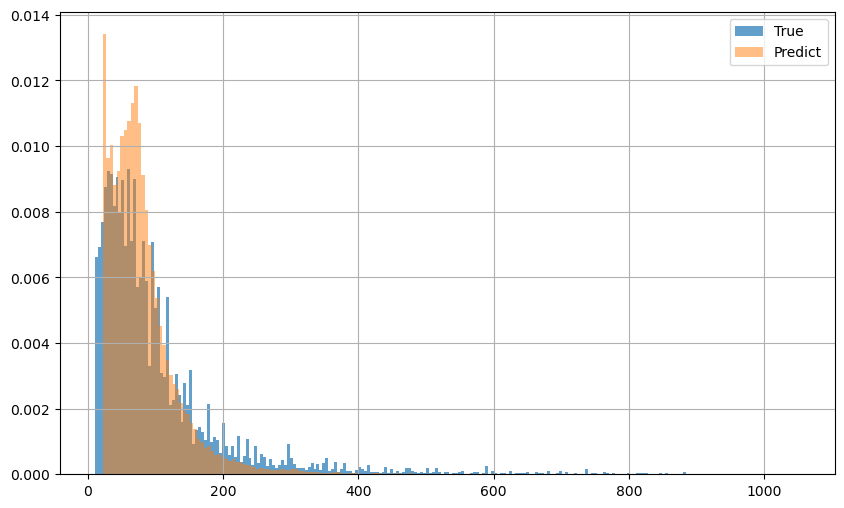

In [155]:
#visualize the distribution
fig,ax = plt.subplots(figsize=(10,6))

ax.hist(Y_test,bins=200,density=True,label='True',alpha=0.7)
ax.hist(Y_pred7,bins=200,density=True,label='Predict',alpha=0.5)

ax.legend(loc='upper right')
ax.grid()

plt.show()

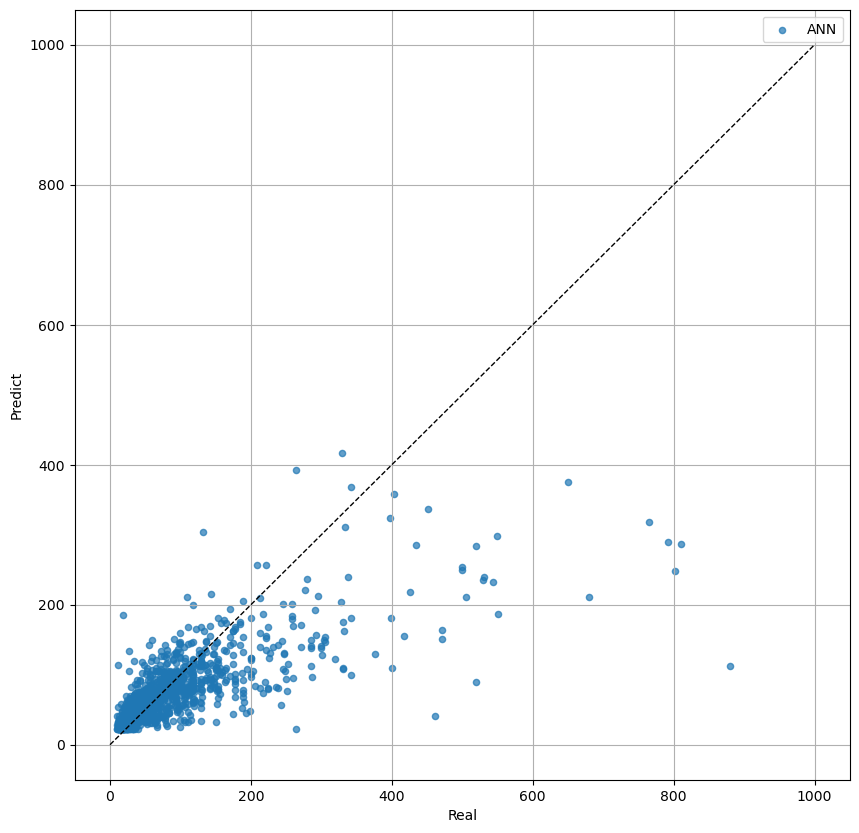

In [225]:
#plot the scatter
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(Y_test[0:1000], Y_pred7[0:1000], label='ANN', s=20, alpha=0.7)
ax.plot((0,1000),(0,1000), '--k', lw=1)

ax.set_xlabel('Real')
ax.set_ylabel('Predict')
ax.legend(loc='upper right')
ax.grid()

plt.show()

In [224]:
#ANN performance
Y_pred1 = np.exp(ann.predict(X_train))
Y_pred2 = np.exp(ann.predict(X_test))
rmse1 = mean_squared_error(Y_train,Y_pred1, squared=False)
rmse2 = mean_squared_error(Y_test,Y_pred2, squared=False)
print('In sample:',rmse1)
print('Out of sample',rmse2)

1713/1713 [==============================] - 3s 2ms/step
In sample: 82.88412341930322
Out of sample 82.46154769820575


From the results, it can be observed that the performance of ANN is only slightly better than that of AdaBoost among the tree models.</br>
In class, I learned about the background of artificial neural networks (ANNs), which are widely used in scenarios like image recognition, such as the MNIST dataset. In image recognition, each pixel's features are highly correlated. However, in tabular data, many features have weak correlations with each other. This stark difference between tabular data and image recognition scenarios leads to ANN's inability to outperform various tree models, even with an increasing number of hidden layers.